In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from utils.plots import vae_plots
from utils.rbm_plots import plot_rbm_histogram
import os
import h5py
from utils.data_exploration import overall_plots
from tqdm import tqdm


Processing eta: 000
using these layers in combined: [0, 1, 2, 3, 12]
using these layers in positive: [0, 1, 2, 3, 12]
using these layers in fine: [0, 1, 2, 3, 12]
Layer 0 has the same shape in both datasets: torch.Size([150000, 336])
Layer 0 in combined dataset has 137325 non-zero events.
Layer 0 in positive dataset has 137325 non-zero events.
Layer 0 dimensions in combined dataset: torch.Size([150000, 336])
Layer 0 dimensions in positive dataset: torch.Size([150000, 336])
Layer 1 has the same shape in both datasets: torch.Size([150000, 336])
Layer 1 in combined dataset has 148990 non-zero events.
Layer 1 in positive dataset has 148990 non-zero events.
Layer 1 dimensions in combined dataset: torch.Size([150000, 336])
Layer 1 dimensions in positive dataset: torch.Size([150000, 336])
Layer 2 has the same shape in both datasets: torch.Size([150000, 336])
Layer 2 in combined dataset has 149860 non-zero events.
Layer 2 in positive dataset has 149860 non-zero events.
Layer 2 dimensions in co

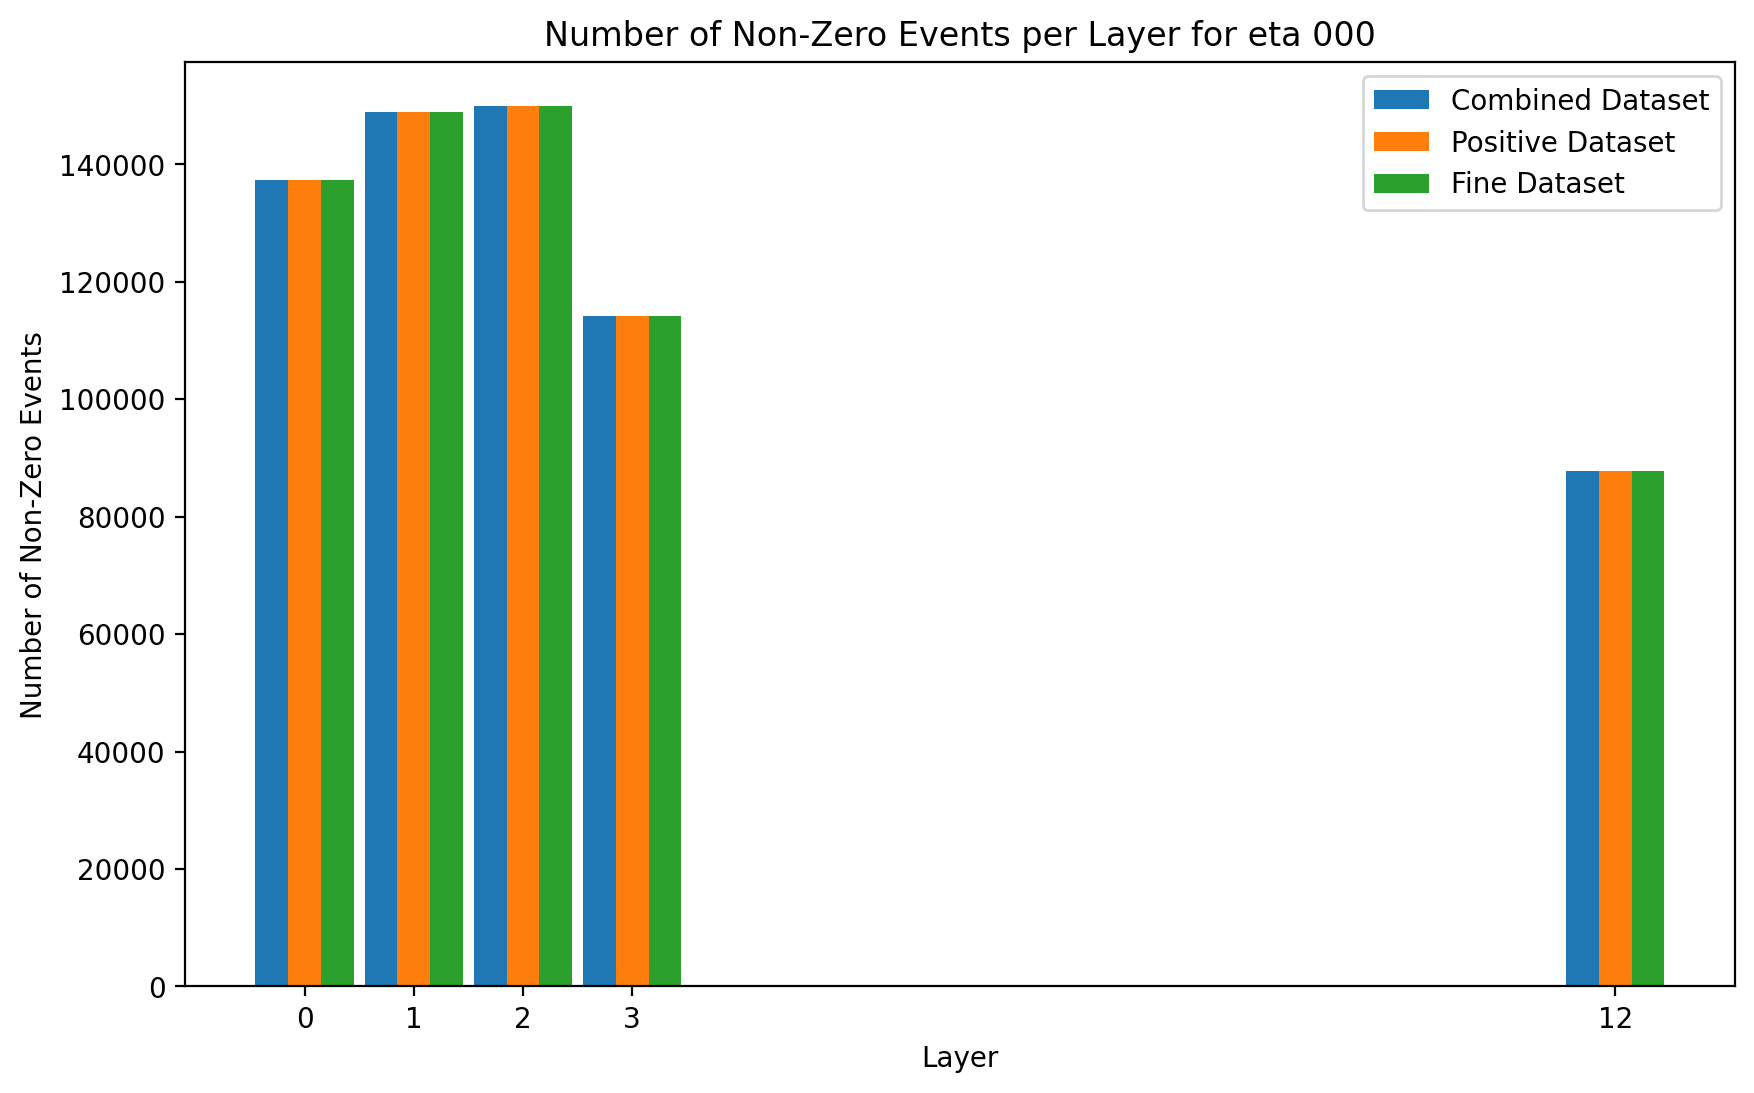

Processing eta: 050
using these layers in combined: [0, 1, 2, 3, 12]
using these layers in positive: [0, 1, 2, 3, 12]
using these layers in fine: [0, 1, 2, 3, 12]
Layer 0 has the same shape in both datasets: torch.Size([150000, 336])
Layer 0 in combined dataset has 140933 non-zero events.
Layer 0 in positive dataset has 140933 non-zero events.
Layer 0 dimensions in combined dataset: torch.Size([150000, 336])
Layer 0 dimensions in positive dataset: torch.Size([150000, 336])
Layer 1 has the same shape in both datasets: torch.Size([150000, 336])
Layer 1 in combined dataset has 149761 non-zero events.
Layer 1 in positive dataset has 149761 non-zero events.
Layer 1 dimensions in combined dataset: torch.Size([150000, 336])
Layer 1 dimensions in positive dataset: torch.Size([150000, 336])
Layer 2 has the same shape in both datasets: torch.Size([150000, 336])
Layer 2 in combined dataset has 149928 non-zero events.
Layer 2 in positive dataset has 149928 non-zero events.
Layer 2 dimensions in co

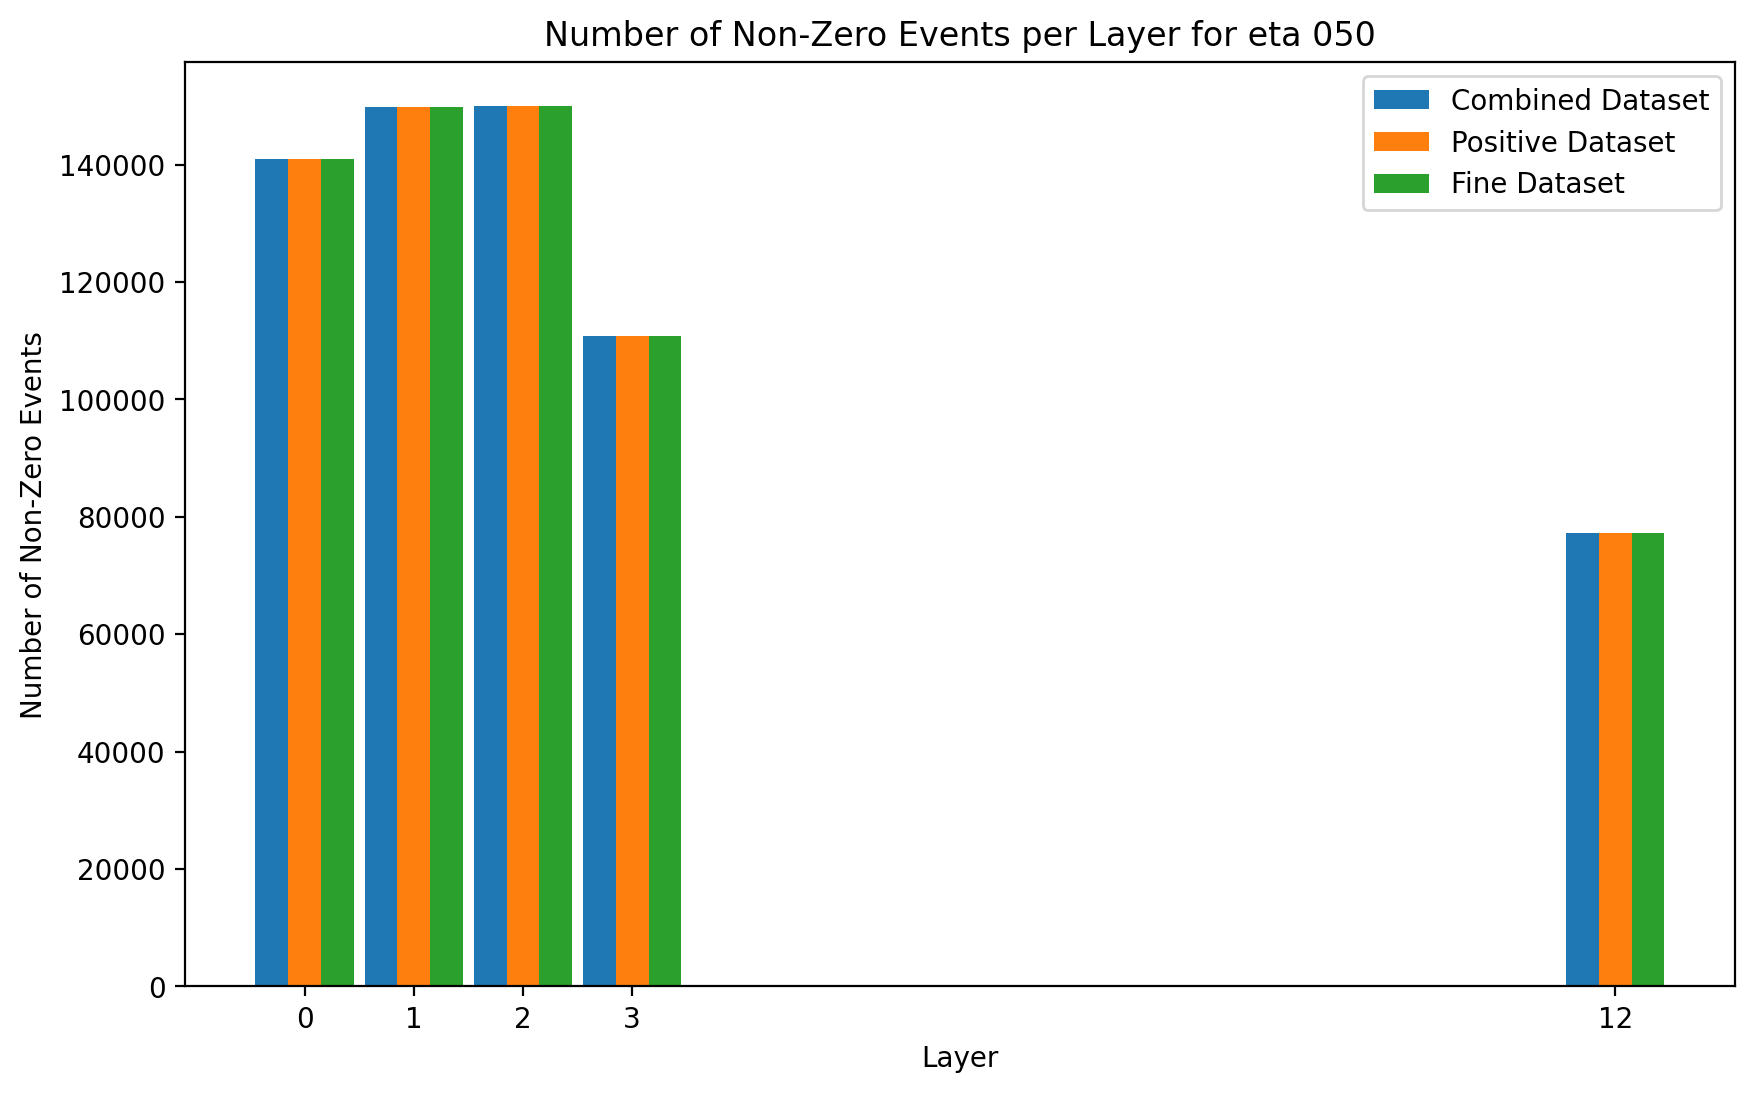

Processing eta: 100
using these layers in combined: [0, 1, 2, 3, 12]
using these layers in positive: [0, 1, 2, 3, 12]
using these layers in fine: [0, 1, 2, 3, 12]
Layer 0 has the same shape in both datasets: torch.Size([150000, 336])
Layer 0 in combined dataset has 146240 non-zero events.
Layer 0 in positive dataset has 146240 non-zero events.
Layer 0 dimensions in combined dataset: torch.Size([150000, 336])
Layer 0 dimensions in positive dataset: torch.Size([150000, 336])
Layer 1 has the same shape in both datasets: torch.Size([150000, 336])
Layer 1 in combined dataset has 149780 non-zero events.
Layer 1 in positive dataset has 149780 non-zero events.
Layer 1 dimensions in combined dataset: torch.Size([150000, 336])
Layer 1 dimensions in positive dataset: torch.Size([150000, 336])
Layer 2 has the same shape in both datasets: torch.Size([150000, 336])
Layer 2 in combined dataset has 149929 non-zero events.
Layer 2 in positive dataset has 149929 non-zero events.
Layer 2 dimensions in co

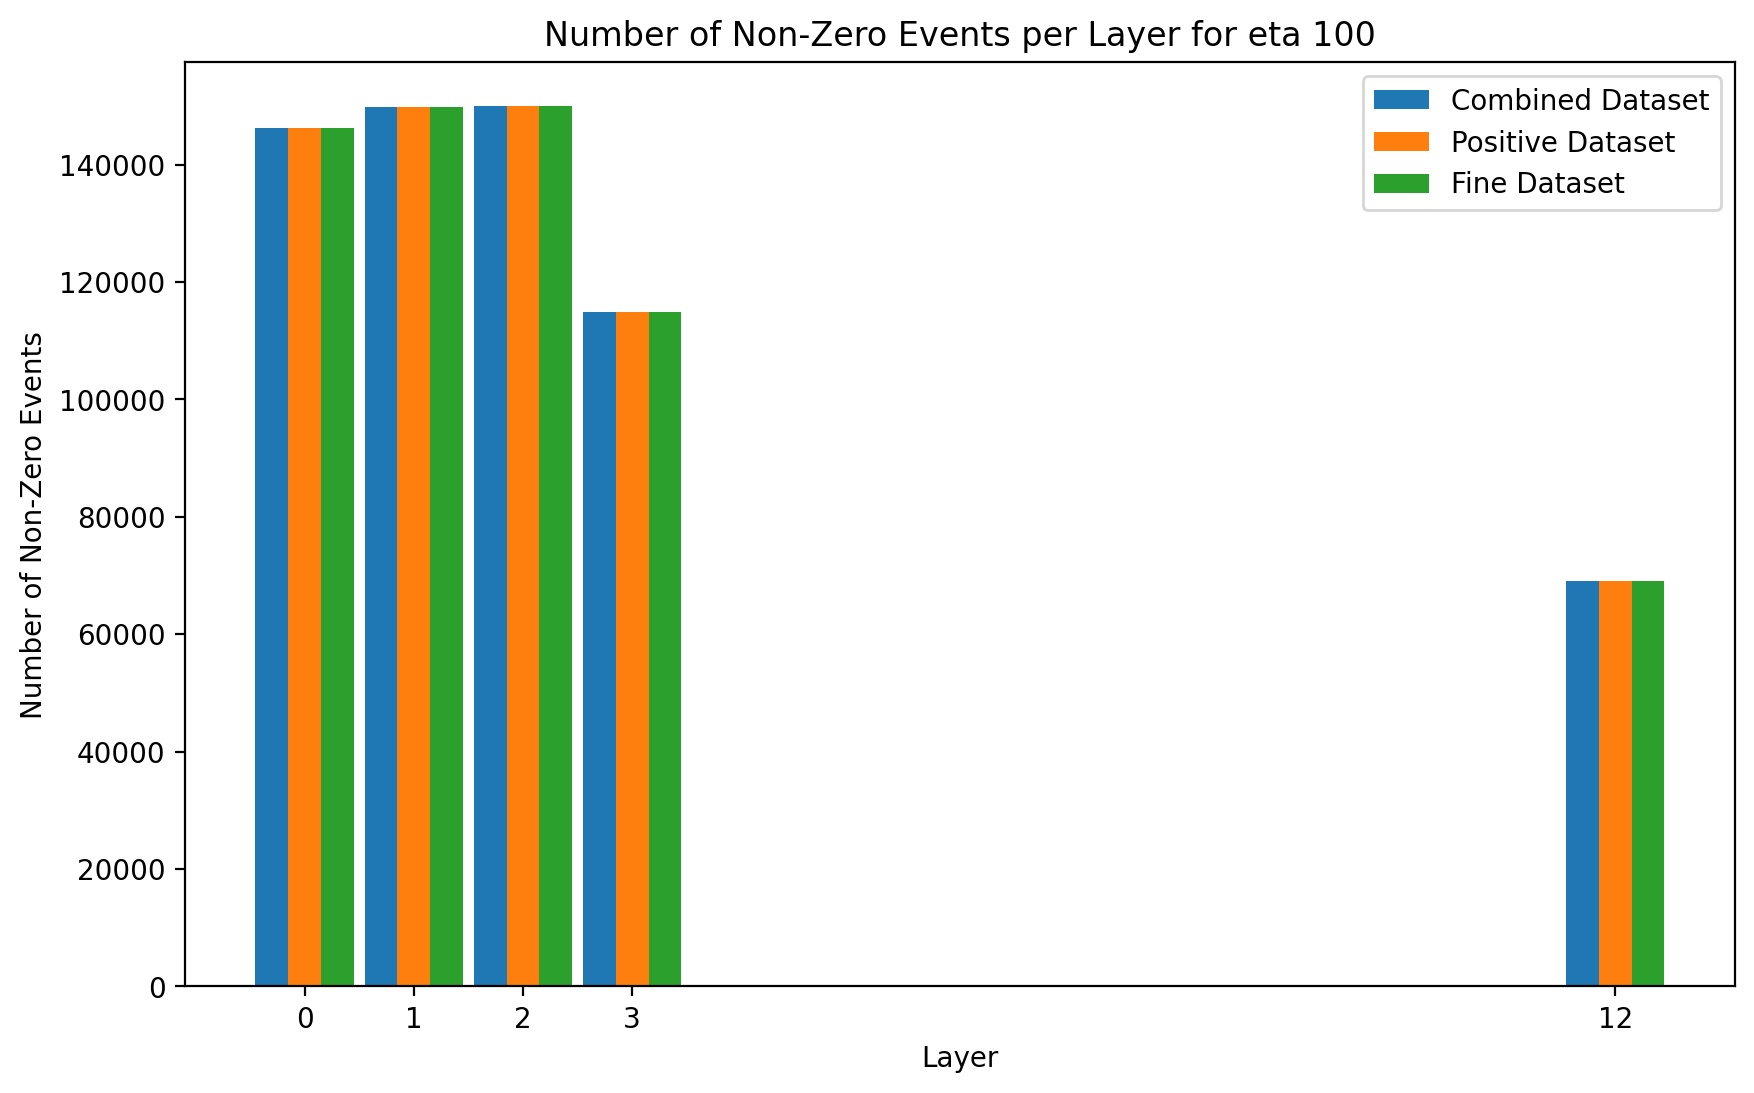

In [13]:
# Compare combined, positive, fine datasets across layers and eta

base_dir = '/fast_scratch_1/caloqvae/data/atlas_july31'
# List top-level keys (groups or datasets)
# print("Combined keys:", list(file_combined.keys()))
# print("Positive keys:", list(file_positive.keys()))
for eta in range(0, 135, 50)[:3]:
    print(f"Processing eta: {eta:03d}")
    file_names = ["dataset_combined.hdf5", "dataset_combined_positive.hdf5", "dataset_combined_fine.hdf5"]
    file_combined = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_names[0]}", 'r')
    file_positive = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_names[1]}", 'r')
    file_fine = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_names[2]}", 'r')


    valid_layers_combined = []
    valid_layers_positive = []
    valid_layers_fine = []
    f_combined = {key: torch.tensor(np.array(file_combined[key])) for key in file_combined.keys()}
    f_positive = {key: torch.tensor(np.array(file_positive[key])) for key in file_positive.keys()}
    f_fine = {key: torch.tensor(np.array(file_fine[key])) for key in file_fine.keys()}
    for layer in range(24):
        key = f'energy_layer_{layer}'
        if key in f_combined:
            if (f_combined[key].sum(dim=1) != 0).any(): #check if layers contain events with nonzero entries
                valid_layers_combined.append(layer)
        if key in f_positive:
            if (f_positive[key].sum(dim=1) != 0).any():
                valid_layers_positive.append(layer)
        if key in f_fine:
            if (f_fine[key].sum(dim=1) != 0).any():
                valid_layers_fine.append(layer)

    print(f"using these layers in combined: {valid_layers_combined}")
    print(f"using these layers in positive: {valid_layers_positive}")
    print(f"using these layers in fine: {valid_layers_fine}")


    # plot number of non-zero events in each layer
    num_events_combined = []
    num_events_positive = []
    num_events_fine = []
    for layer in valid_layers_combined:
        key = f'energy_layer_{layer}'
        if key in f_combined and key in f_positive and key in f_fine:
            shape_combined = f_combined[key].shape
            shape_positive = f_positive[key].shape
            shape_fine = f_fine[key].shape
            if shape_combined != shape_positive:
                print(f"Shape mismatch for layer {layer}: combined {shape_combined}, positive {shape_positive}")
            else:
                print(f"Layer {layer} has the same shape in both datasets: {shape_combined}")
            print(f"Layer {layer} in combined dataset has {f_combined[key].sum(dim=1).nonzero().shape[0]} non-zero events.")
            print(f"Layer {layer} in positive dataset has {f_positive[key].sum(dim=1).nonzero().shape[0]} non-zero events.")
            num_events_fine.append(f_fine[key])
            num_events_combined.append(f_combined[key])
            num_events_positive.append(f_positive[key])
            # print dimensions of the layer
            print(f"Layer {layer} dimensions in combined dataset: {f_combined[key].shape}")
            print(f"Layer {layer} dimensions in positive dataset: {f_positive[key].shape}")
        else:
            print(f"Layer {layer} is missing in one of the datasets.")
    # Plot number of non-zero events in each layer
    plt.figure(figsize=(10, 6))
    plt.bar(np.array(valid_layers_combined)-0.3, [ (layer.sum(dim=1) != 0).sum().item() for layer in num_events_combined], width=0.3, label='Combined Dataset')
    plt.bar(np.array(valid_layers_positive), [ (layer.sum(dim=1) != 0).sum().item() for layer in num_events_positive], width=0.3, label='Positive Dataset')
    plt.bar(np.array(valid_layers_fine)+0.3, [ (layer.sum(dim=1) != 0).sum().item() for layer in num_events_fine], width=0.3, label='Fine Dataset')
    plt.xlabel('Layer')
    plt.ylabel('Number of Non-Zero Events')
    plt.title(f'Number of Non-Zero Events per Layer for eta {eta:03d}')
    plt.xticks(valid_layers_combined)
    plt.legend()
    plt.show()

In [ ]:
input_dir_base = "/fast_scratch_1/caloqvae/data/atlas_july31"
output_dir_base = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"

for eta in range(0, 135, 5):
    print(f"Processing eta {eta}")
    input_dir = input_dir_base + f"/eta_{eta:03d}" + f"/eta_{eta:03d}_regular_binning"
    output_dir = output_dir_base + f"/eta_{eta:03d}" + f"/eta_{eta:03d}_regular_binning"
    print(f"Output directory: {output_dir}")
    os.makedirs(output_dir, exist_ok=True)
    file_name = f"{input_dir}/dataset_combined.hdf5"
    file_positive_name = f"{input_dir}/dataset_combined_positive.hdf5"
    file_fine_name = f"{input_dir}/dataset_combined_fine.hdf5"
    file_combined = h5py.File(file_name, 'r')
    file_positive = h5py.File(file_positive_name, 'r')
    file_fine = h5py.File(file_fine_name, 'r')
    valid_layers_combined = []
    valid_layers_positive = []
    valid_layers_fine = []
    f_combined = {key: torch.tensor(np.array(file_combined[key])) for key in file_combined.keys()}
    f_positive = {key: torch.tensor(np.array(file_positive[key])) for key in file_positive.keys()}
    f_fine = {key: torch.tensor(np.array(file_fine[key])) for key in file_fine.keys()}
    for layer in range(24):
        key = f'energy_layer_{layer}'
        if key in f_combined:
            if (f_combined[key].sum(dim=1) != 0).any(): #check if layers contain events with nonzero entries
                valid_layers_combined.append(layer)
        if key in f_positive:
            if (f_positive[key].sum(dim=1) != 0).any():
                valid_layers_positive.append(layer)
        if key in f_fine:
            if (f_fine[key].sum(dim=1) != 0).any():
                valid_layers_fine.append(layer)
    print(f"using these layers in combined: {valid_layers_combined}")
    print(f"using these layers in positive: {valid_layers_positive}")
    print(f"using these layers in fine: {valid_layers_fine}")

    # concatenate across layers for all 3 datasets
    showers = torch.cat([f_combined[f'energy_layer_{layer}'] for layer in valid_layers_combined], dim=1)
    showers_positive = torch.cat([f_positive[f'energy_layer_{layer}'] for layer in valid_layers_positive], dim=1)
    showers_fine = torch.cat([f_fine[f'energy_layer_{layer}'] for layer in valid_layers_fine], dim=1)

    showers_scaled = (showers * f_combined['incident_energy'].unsqueeze(1)).numpy()
    showers_positive_scaled = (showers_positive * f_positive['incident_energy'].unsqueeze(1)).numpy()
    showers_fine_scaled = (showers_fine * f_fine['incident_energy'].unsqueeze(1)).numpy()

    incident_energy_combined = f_combined['incident_energy'].numpy()
    incident_energy_positive = f_positive['incident_energy'].numpy()
    incident_energy_fine = f_fine['incident_energy'].numpy()

    with h5py.File(f"{output_dir}/dataset_combined_cat.hdf5", 'w') as f_out:
        f_out.create_dataset('showers', data=showers_scaled)
        f_out.create_dataset('incident_energy', data=incident_energy_combined)

    with h5py.File(f"{output_dir}/dataset_positive_cat.hdf5", 'w') as f_out:
        f_out.create_dataset('showers', data=showers_positive_scaled)
        f_out.create_dataset('incident_energy', data=incident_energy_positive)

    with h5py.File(f"{output_dir}/dataset_fine_cat.hdf5", 'w') as f_out:
        f_out.create_dataset('showers', data=showers_fine_scaled)
        f_out.create_dataset('incident_energy', data=incident_energy_fine)
    print(f"Saved combined dataset to {output_dir}/dataset_combined_cat.hdf5")
    print(f"Saved positive dataset to {output_dir}/dataset_positive_cat.hdf5")
    print(f"Saved fine dataset to {output_dir}/dataset_fine_cat.hdf5")

In [11]:
base_path = "/fast_scratch_1/caloqvae/data/atlas_july31"
output_dir_base = "/fast_scratch_1/caloqvae/data/atlas_july31_rebuilt"


def load_showers_and_incident_energy(path, valid_layers):
    with h5py.File(path, 'r') as file:
        data = {key: torch.tensor(file[key][:]) for key in file.keys()}
        incident_energy = data["incident_energy"]

        combined = torch.cat([data[f"energy_layer_{l}"] for l in valid_layers], dim=1)
        showers = combined * incident_energy.unsqueeze(1)
        return showers.numpy(), incident_energy.numpy()

def get_global_valid_layers(split_paths):
    global_valid_layers = set()
    for path in split_paths:
        with h5py.File(path, 'r') as file:
            data = {key: torch.tensor(file[key][:]) for key in file.keys()}
            for l in range(24):
                key = f"energy_layer_{l}"
                if key in data and (data[key].sum(dim=1) != 0).any():
                    global_valid_layers.add(l)
    return sorted(global_valid_layers)

eta_dirs = [f"eta_{i:03d}" for i in range(0, 135, 5)]
file_names = ["dataset_combined.hdf5", "dataset_combined_positive.hdf5", "dataset_combined_fine.hdf5"]

for eta_tag in tqdm(eta_dirs):
    regular_dir = os.path.join(base_path, eta_tag, f"{eta_tag}_regular_binning")
    global_valid_layers_dict = {file_name: set() for file_name in file_names}
    showers_dict = {file_name: [] for file_name in file_names}
    incident_energy_dict = {file_name: [] for file_name in file_names}

    split_paths = {file_name: [os.path.join(regular_dir, str(i), file_name) for i in range(20)] for file_name in file_names}
    for file_name, paths in split_paths.items():
        global_valid_layers_dict[file_name] = get_global_valid_layers(paths)

    print(f"Global valid layers for {eta_tag}: {global_valid_layers_dict}")
    # for i in range(20):
    #     for file_name in file_names:
    #         split_path = os.path.join(regular_dir, str(i), file_name)
    #         if os.path.exists(split_path):
    #             showers, incident_energy = load_showers_and_incident_energy(split_path, global_valid_layers_dict[file_name])
    #             if showers is not None:
    #                 showers_dict[file_name].append(showers)
    #                 incident_energy_dict[file_name].append(incident_energy)
    # output_dir = os.path.join(output_dir_base, eta_tag, f"{eta_tag}_regular_binning")
    # os.makedirs(output_dir, exist_ok=True)

    # for file_name in file_names:
    #     shapes = [s.shape[1] for s in showers_dict[file_name]]
    #     if len(set(shapes)) > 1:
    #         print(f"Inconsistent shape for {file_name} at {eta_tag}: {len(set(shapes))} unique shapes instead of 1")
    #         continue
    #     showers_dict[file_name] = np.concatenate(showers_dict[file_name], axis=0)
    #     incident_energy_dict[file_name] = np.concatenate(incident_energy_dict[file_name], axis=0)
    #     with h5py.File(os.path.join(output_dir, file_name.split(".")[0]+"_rebuilt.hdf5"), 'w') as f_out:
    #         f_out.create_dataset('showers', data=showers_dict[file_name])
    #         f_out.create_dataset('incident_energy', data=incident_energy_dict[file_name])
    # print(f"Rebuilt dataset saved for {eta_tag} in {output_dir}")

  4%|███████▌                                                                                                                                                                                                    | 1/27 [00:32<14:02, 32.39s/it]

Global valid layers for eta_000: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


  7%|███████████████                                                                                                                                                                                             | 2/27 [01:02<12:59, 31.17s/it]

Global valid layers for eta_005: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 11%|██████████████████████▋                                                                                                                                                                                     | 3/27 [01:36<12:55, 32.29s/it]

Global valid layers for eta_010: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 15%|██████████████████████████████▏                                                                                                                                                                             | 4/27 [02:11<12:52, 33.59s/it]

Global valid layers for eta_015: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 19%|█████████████████████████████████████▊                                                                                                                                                                      | 5/27 [02:46<12:24, 33.82s/it]

Global valid layers for eta_020: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 22%|█████████████████████████████████████████████▎                                                                                                                                                              | 6/27 [03:23<12:13, 34.95s/it]

Global valid layers for eta_025: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 26%|████████████████████████████████████████████████████▉                                                                                                                                                       | 7/27 [03:58<11:42, 35.14s/it]

Global valid layers for eta_030: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                               | 8/27 [04:30<10:49, 34.19s/it]

Global valid layers for eta_035: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 33%|████████████████████████████████████████████████████████████████████                                                                                                                                        | 9/27 [05:07<10:26, 34.80s/it]

Global valid layers for eta_040: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 10/27 [05:44<10:06, 35.69s/it]

Global valid layers for eta_045: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 11/27 [06:15<09:08, 34.30s/it]

Global valid layers for eta_050: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14]}


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 12/27 [06:49<08:30, 34.02s/it]

Global valid layers for eta_055: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14, 16, 20], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14, 16, 20], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14, 16, 20]}


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 13/27 [07:22<07:52, 33.78s/it]

Global valid layers for eta_060: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 20], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 20], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 20]}


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 14/27 [07:57<07:24, 34.22s/it]

Global valid layers for eta_065: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 19, 20], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 19, 20], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 19, 20]}


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 15/27 [08:30<06:46, 33.84s/it]

Global valid layers for eta_070: {'dataset_combined.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 18, 19, 20], 'dataset_combined_positive.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 18, 19, 20], 'dataset_combined_fine.hdf5': [0, 1, 2, 3, 12, 13, 14, 15, 16, 18, 19, 20]}


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 15/27 [08:59<07:11, 35.96s/it]


KeyboardInterrupt: 

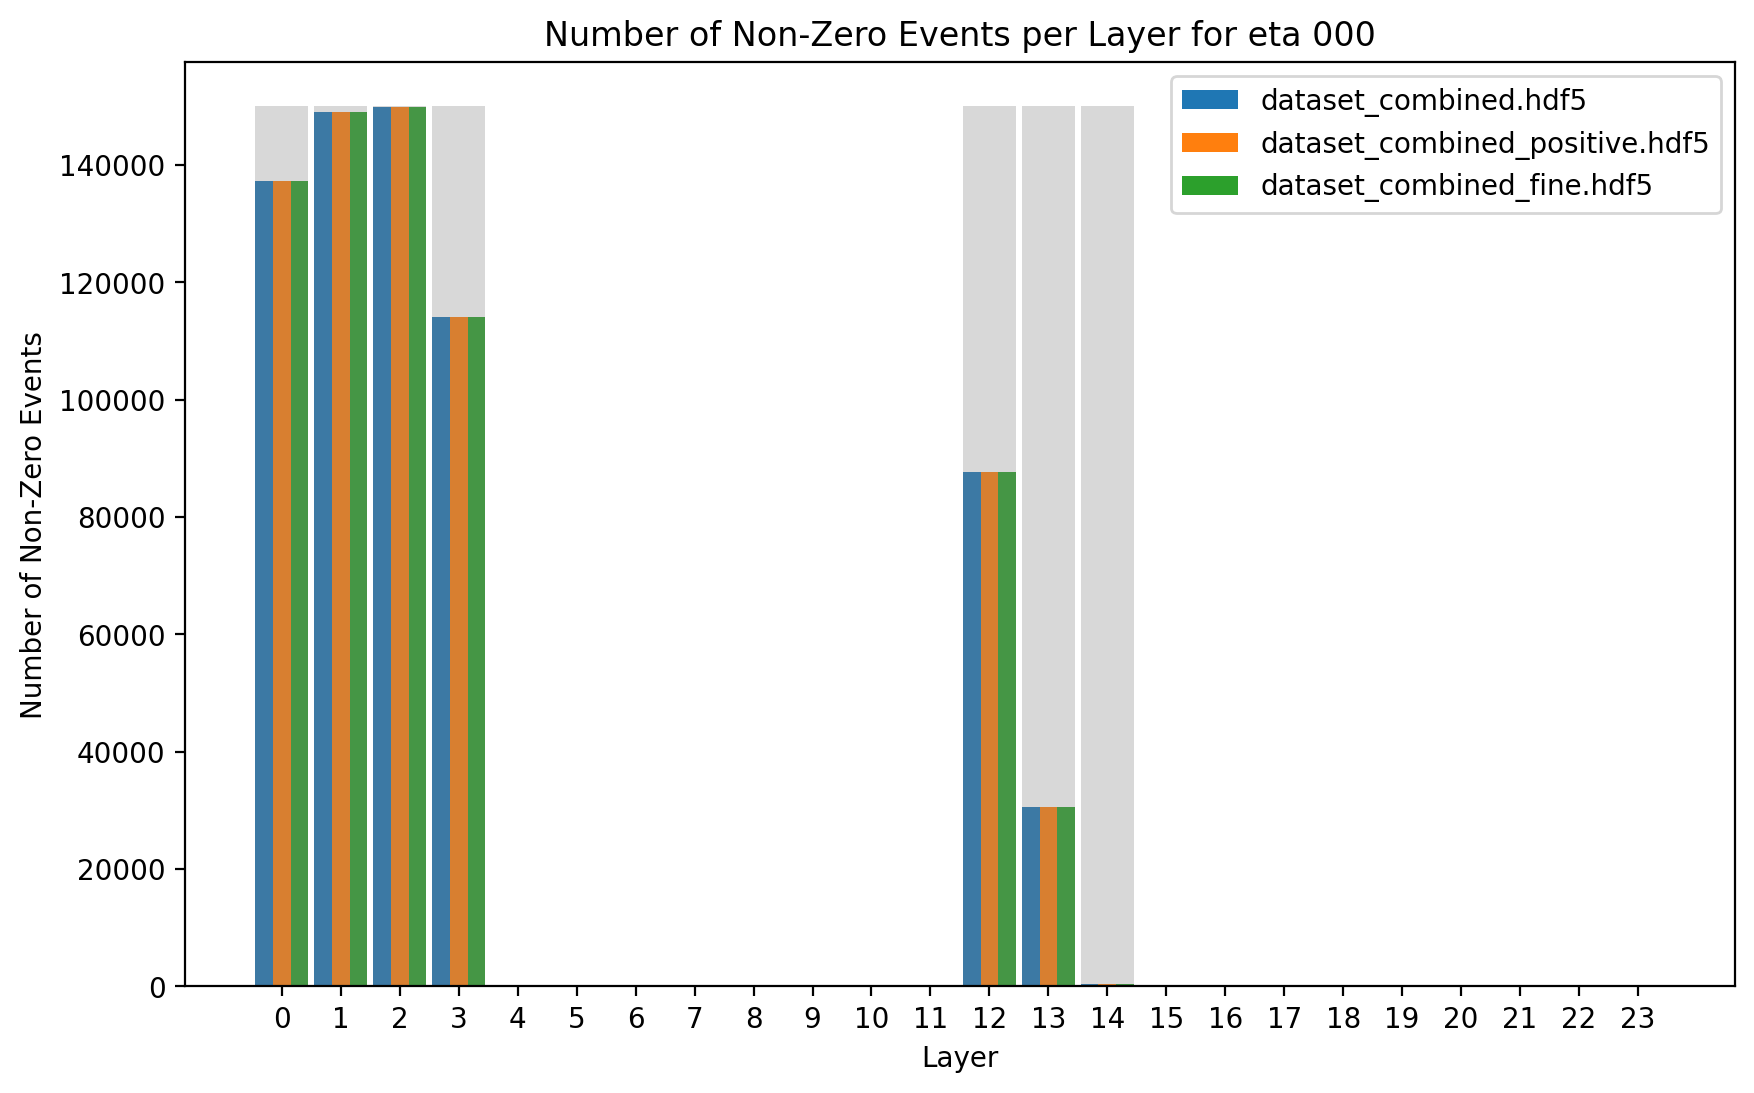

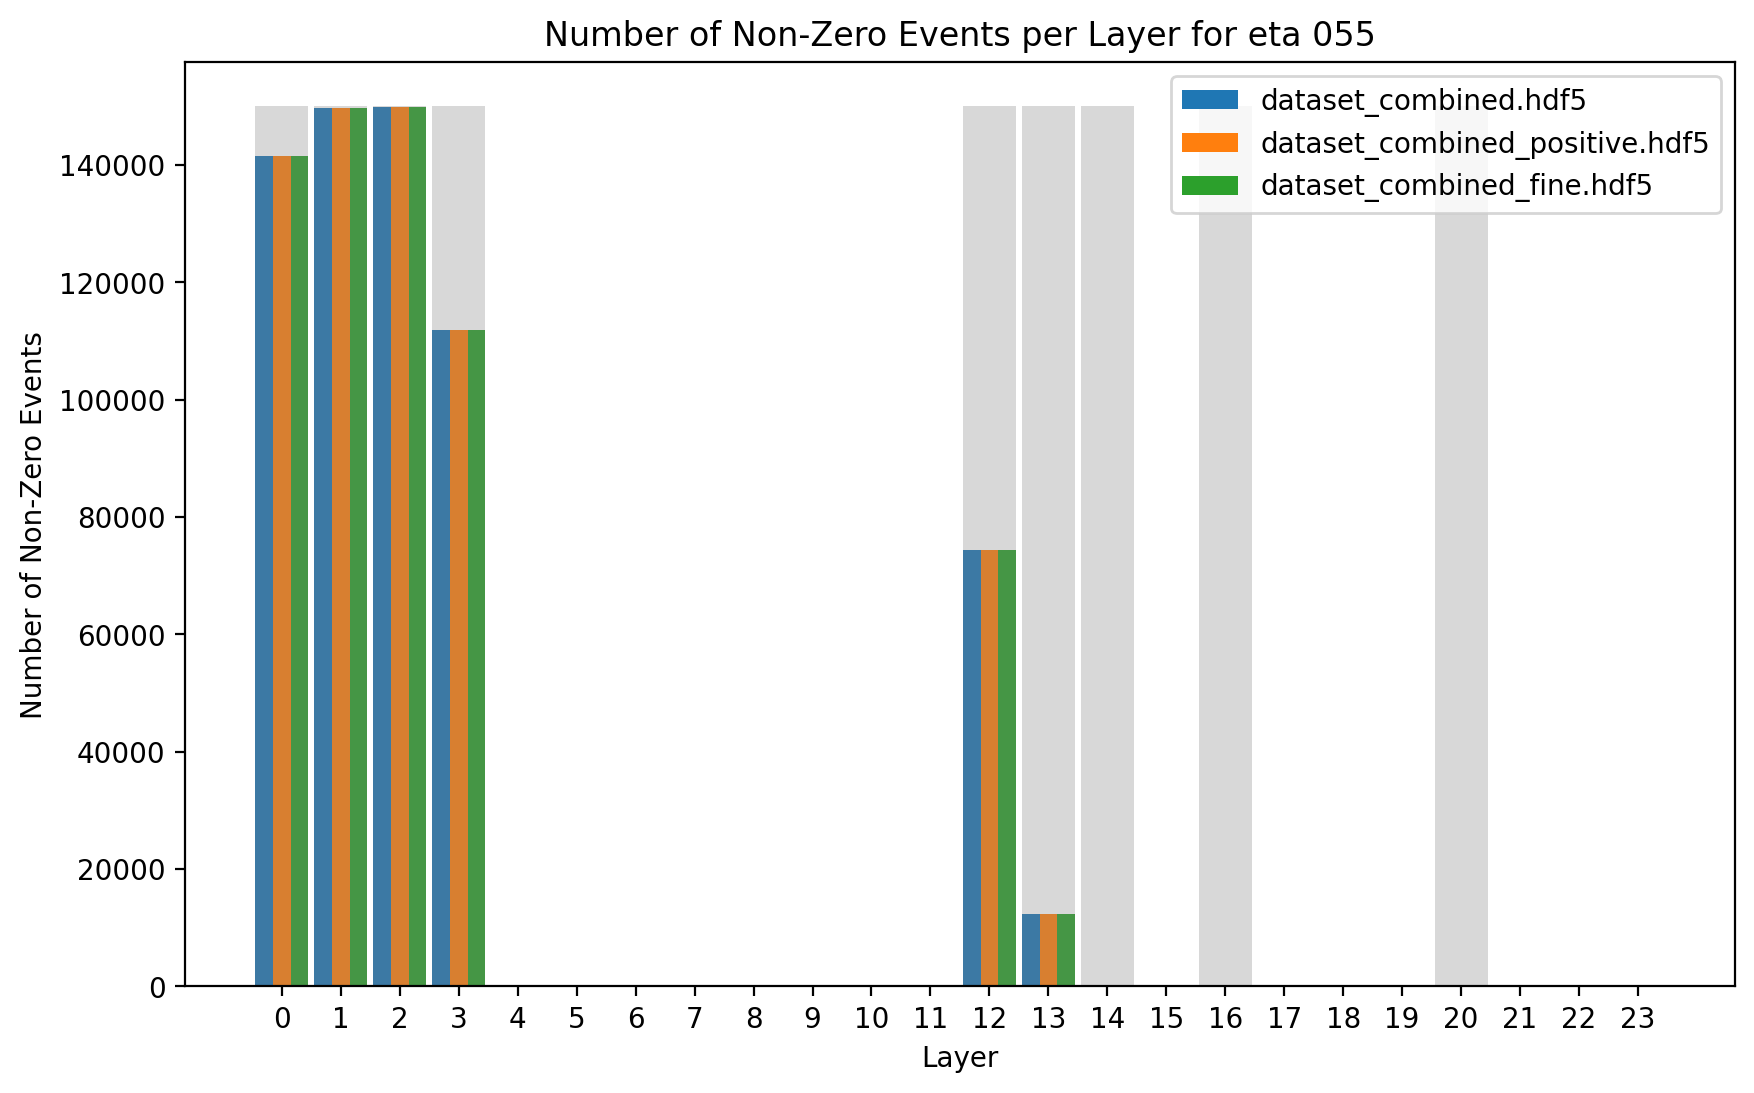

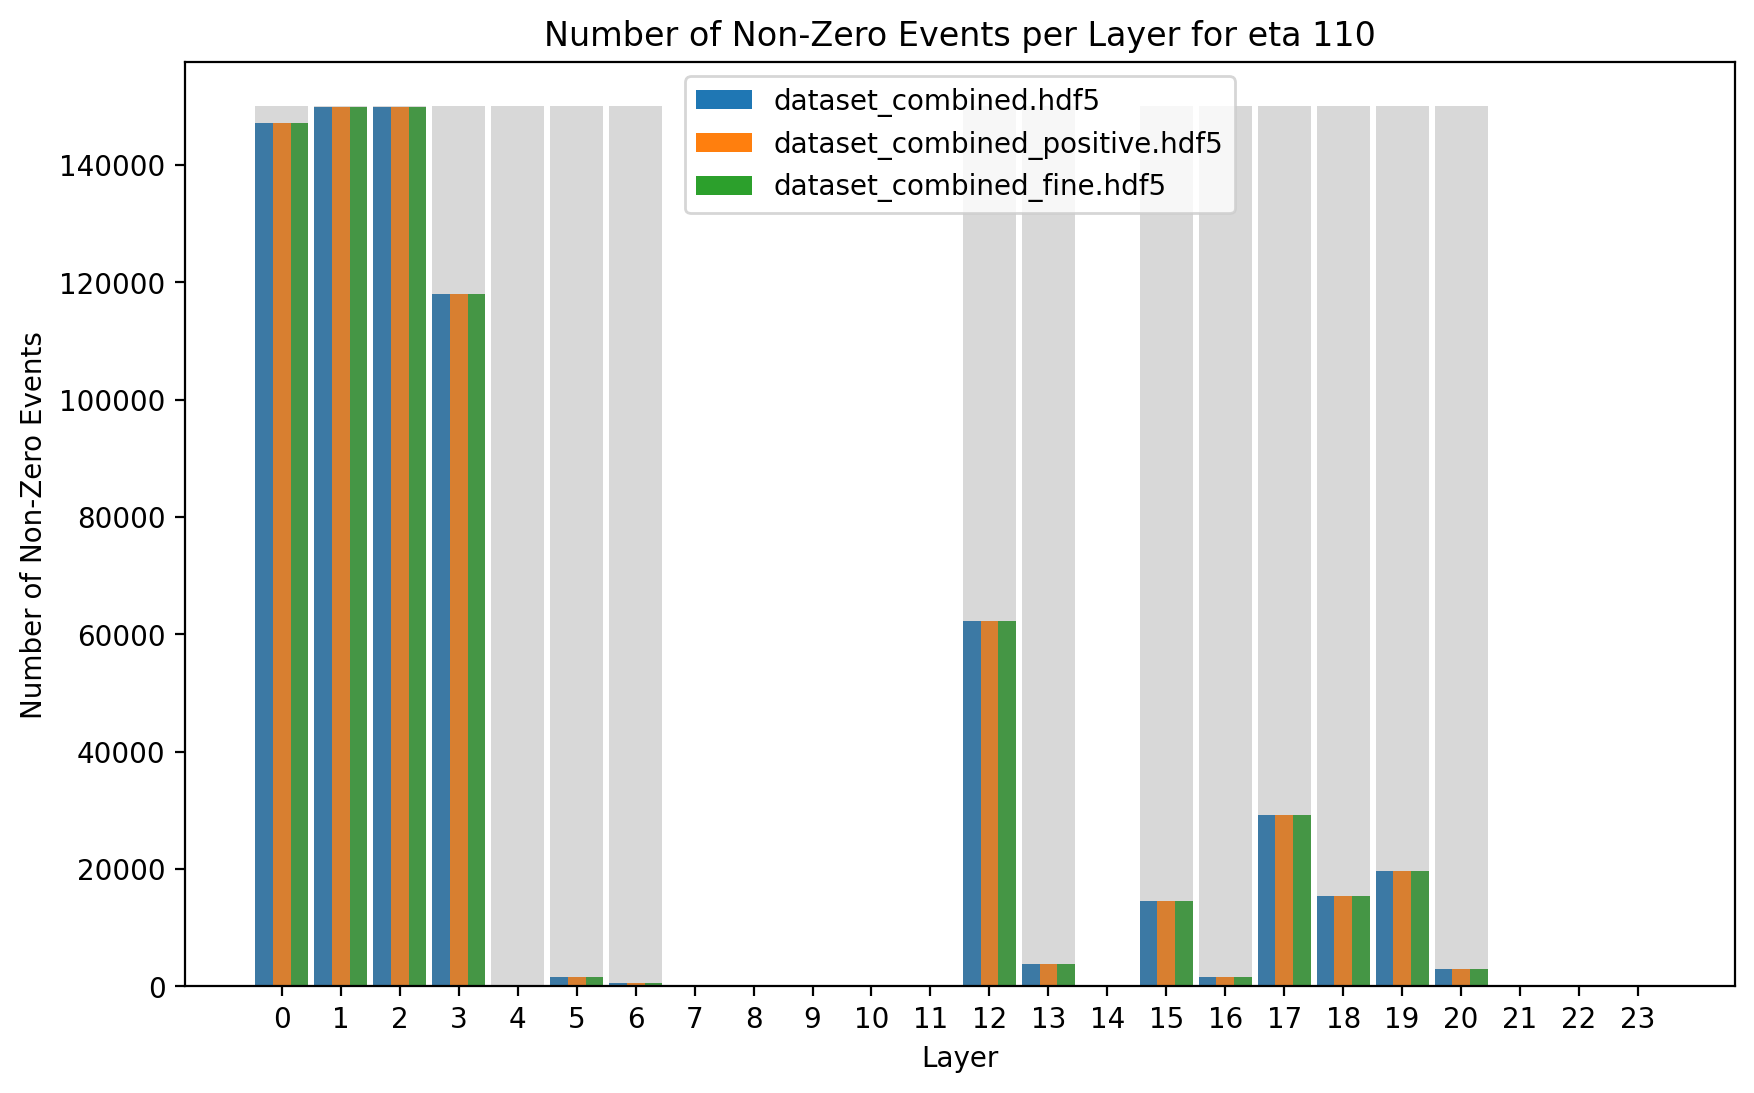

In [15]:
base_path = "/fast_scratch_1/caloqvae/data/atlas_july31"
def get_global_layer_counts(split_paths):
    global_layer_counts = {}
    for path in split_paths:
        with h5py.File(path, 'r') as file:
            file = {key: torch.tensor(file[key][:]) for key in file.keys()}
            for l in range(24):
                key = f"energy_layer_{l}"
                if key in file:
                    if l not in global_layer_counts:
                        global_layer_counts[l] = 0
                    global_layer_counts[l] += file[key].sum(dim=1).nonzero().shape[0]
    return global_layer_counts

file_names = ["dataset_combined.hdf5", "dataset_combined_positive.hdf5", "dataset_combined_fine.hdf5"]
for eta in range(0, 135, 55)[:3]:
    eta_tag = f"eta_{eta:03d}"
    regular_dir = os.path.join(base_path, eta_tag, f"{eta_tag}_regular_binning")
    global_layer_counts_dict = {file_name: {} for file_name in file_names}
    split_paths = {file_name: [os.path.join(regular_dir, str(i), file_name) for i in range(20)] for file_name in file_names}
    for file_name, paths in split_paths.items():
        global_layer_counts_dict[file_name] = get_global_layer_counts(paths)
    plt.figure(figsize=(10, 6))
    width = 0.3
    for i, file_name in enumerate(file_names):
        layer_counts = global_layer_counts_dict[file_name]
        plt.bar(np.array(list(layer_counts.keys())) + i * width - width, list(layer_counts.values()), width=width, label=file_name)
        # if count is non-zero, draw a transparent bar to show layer is activated even when counts are very low
        plt.bar(np.array(list(layer_counts.keys())) + i * width - width, [1.5e5 if layer_counts[l] > 0 else 0 for l in layer_counts], width=width, alpha=0.3, color='gray')
    plt.xlabel('Layer')
    plt.ylabel('Number of Non-Zero Events')
    plt.title(f'Number of Non-Zero Events per Layer for eta {eta:03d}')
    plt.xticks(range(24))
    plt.legend()


In [ ]:
import importlib
import utils.data_exploration
importlib.reload(utils.data_exploration)
from utils.data_exploration import get_global_valid_layers, load_showers_and_incident_energy
base_path = "/fast_scratch_1/caloqvae/data/atlas_july31_rebuilt"

#print shower shapes across eta
eta_dirs = [f"eta_{i:03d}" for i in range(0, 135, 5)]
file_names = ["dataset_combined.hdf5", "dataset_combined_positive.hdf5", "dataset_combined_fine.hdf5"]
for eta_tag in tqdm(eta_dirs):
    regular_dir = os.path.join(base_path, eta_tag, f"{eta_tag}_regular_binning")
    for file_name in file_names:
        combined_path = os.path.join(regular_dir, file_name.split(".")[0] + "_rebuilt.hdf5")
        with h5py.File(combined_path, 'r') as f:
            showers = f['showers'][:]
            incident_energy = f['incident_energy'][:]
            print(f"Showers shape for {file_name} at {eta_tag}: {showers.shape}")
            print(f"Incident energy shape for {file_name} at {eta_tag}: {incident_energy.shape}")
        if os.path.exists(os.path.join(regular_dir, file_name+"_rebuilt.hdf5")):
            os.remove(os.path.join(regular_dir, file_name+"_rebuilt.hdf5"))  # Clean up after checking

In [ ]:
import importlib
import utils.data_exploration
importlib.reload(utils.data_exploration)
from utils.data_exploration import compare_datasets, load_showers_and_incident_energy

combined_path = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
rebuilt_path = "/fast_scratch_1/caloqvae/data/atlas_july31_rebuilt"
for eta in range(0, 135, 5)[:1]:
    eta_tag = f"eta_{eta:03d}"
    print(f"Comparing datasets for {eta_tag}")
    combined_file = os.path.join(combined_path, eta_tag, f"{eta_tag}_regular_binning", "dataset_positive_cat.hdf5")
    rebuilt_file = os.path.join(rebuilt_path, eta_tag, f"{eta_tag}_regular_binning", "dataset_combined_positive_rebuilt.hdf5")
    if os.path.exists(combined_file) and os.path.exists(rebuilt_file):
        combined_showers, combined_incident_energy = load_showers_and_incident_energy(combined_file, None)
        rebuilt_showers, rebuilt_incident_energy = load_showers_and_incident_energy(rebuilt_file, None)
        compare_datasets(combined_incident_energy, combined_showers, rebuilt_incident_energy, rebuilt_showers)
    else:
        print(f"One of the files does not exist for {eta_tag}: {combined_file}, {rebuilt_file}")



In [ ]:
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
for eta in tqdm(range(0, 135, 5)):
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    for file_name in file_names:
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r') as file:
            showers = torch.from_numpy(file['showers'][:])
            incident_energy = torch.from_numpy(file['incident_energy'][:]).squeeze()

        row_max = torch.amax(showers, dim=1)
        bad_mask = row_max >= incident_energy
        good_mask = ~bad_mask

        n_bad = int(bad_mask.sum())
        n_good = int(good_mask.sum())

        print(f"File: {file_name}, Eta: {eta}, Bad events: {n_bad}, Good events: {n_good}")

        clean_showers = showers[good_mask]
        clean_incident_energy = incident_energy[good_mask]

        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name.split('.')[0]}_clean.hdf5", 'w') as f_out:
            f_out.create_dataset('showers', data=clean_showers.numpy())
            f_out.create_dataset('incident_energies', data=clean_incident_energy.numpy())
        if os.path.exists(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}_clean"):
            os.remove(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}_clean")
        print(f"Saved cleaned dataset to {base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name.split('.')[0]}_clean.hdf5")



In [ ]:
# plot number of bad events in combined, positive, and fine for each eta
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
n_bad_combined = []
n_bad_positive = []
n_bad_fine = []

for eta in range(0, 135, 5):
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    for file_name in file_names:
        file = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r')
        showers = torch.from_numpy(file['showers'][:])
        incident_energy = torch.from_numpy(file['incident_energy'][:]).squeeze()

        row_max = torch.amax(showers, dim=1)
        bad_mask = row_max >= incident_energy
        n_bad = int(bad_mask.sum())

        if "combined" in file_name:
            n_bad_combined.append(n_bad)
        elif "positive" in file_name:
            n_bad_positive.append(n_bad)
        elif "fine" in file_name:
            n_bad_fine.append(n_bad)

plt.figure(figsize=(10, 6))
num_bins = len(n_bad_combined)
eta_centres = np.arange(num_bins) * 5
bin_width = 5/3
plt.bar(eta_centres - bin_width, n_bad_combined, width=bin_width, label='Combined Dataset')
plt.bar(eta_centres, n_bad_positive, width=bin_width, label='Positive Dataset')
plt.bar(eta_centres + bin_width, n_bad_fine, width=bin_width, label='Fine Dataset')
plt.xlabel('Eta')
plt.ylabel('Number of Bad Events')
plt.title('Number of Bad Events in Datasets by Eta')
plt.legend()
print(len(n_bad_combined), len(n_bad_positive), len(n_bad_fine))

In [ ]:
import importlib
import utils.data_exploration
importlib.reload(utils.data_exploration)
from utils.data_exploration import overall_plots
from utils.data_exploration import check_negatives
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
n_bad_combined = []
n_bad_positive = []
n_bad_fine = []

for eta in range(0, 135, 5)[:1]:
    print(f"Processing eta: {eta:03d}")
    showers = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_combined_cat.hdf5", 'r')['showers'][:])
    incident_energy = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_combined_cat.hdf5", 'r')['incident_energy'][:])
    showers_pos = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_positive_cat.hdf5", 'r')['showers'][:])
    incident_energy_pos = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_positive_cat.hdf5", 'r')['incident_energy'][:])
    showers_fine = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_fine_cat.hdf5", 'r')['showers'][:])
    incident_energy_fine = torch.from_numpy(h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_fine_cat.hdf5", 'r')['incident_energy'][:])

    overall_plots(incident_energy, incident_energy_pos, incident_energy_fine, showers, showers_pos, showers_fine)
    check_negatives(showers)


Processing eta: 000
Processing eta: 005
Processing eta: 010
Processing eta: 015
Processing eta: 020
Processing eta: 025
Processing eta: 030
Processing eta: 035
Processing eta: 040
Processing eta: 045
Processing eta: 050
Processing eta: 055
Processing eta: 060
Processing eta: 065
Processing eta: 070
Processing eta: 075
Processing eta: 080
Processing eta: 085
Processing eta: 090
Processing eta: 095
Processing eta: 100
Processing eta: 105
Processing eta: 110
Processing eta: 115
Processing eta: 120
Processing eta: 125
Processing eta: 130


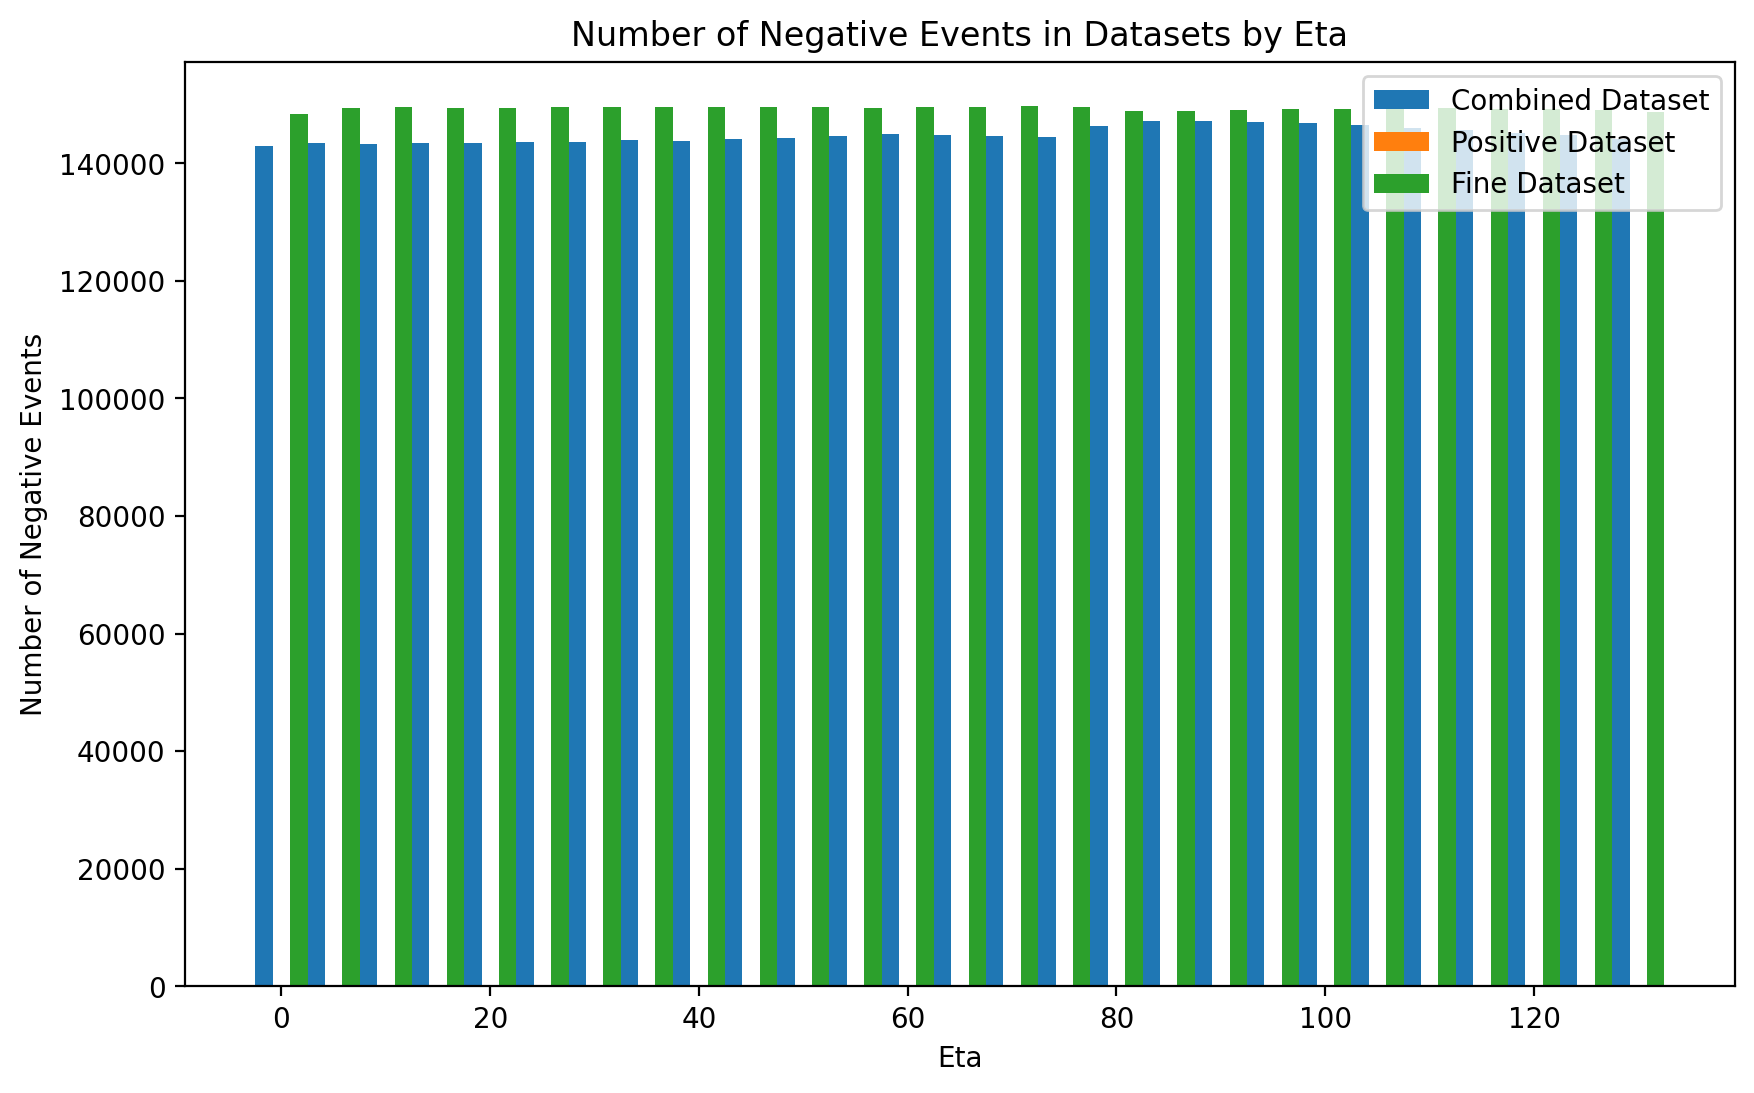

In [42]:
# plot counts of the number of negative events in showers
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
n_negative = []
n_negative_positive = []
n_negative_fine = []
for eta in range(0, 135, 5):
    print(f"Processing eta: {eta:03d}")
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    for file_name in file_names:
        file = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r')
        showers = torch.from_numpy(file['showers'][:])
        incident_energy = torch.from_numpy(file['incident_energy'][:]).squeeze()

        row_min = torch.amin(showers, dim=1)
        bad_mask = row_min < 0
        good_mask = ~bad_mask

        n_bad = int(bad_mask.sum())
        n_good = int(good_mask.sum())

        if "combined" in file_name:
            n_negative.append(n_bad)
        elif "positive" in file_name:
            n_negative_positive.append(n_bad)
        elif "fine" in file_name:
            n_negative_fine.append(n_bad)
plt.figure(figsize=(10, 6))
num_bins = len(n_negative)
eta_centres = np.arange(num_bins) * 5
bin_width = 5/3
plt.bar(eta_centres - bin_width, n_negative, width=bin_width, label='Combined Dataset')
plt.bar(eta_centres, n_negative_positive, width=bin_width, label='Positive Dataset')
plt.bar(eta_centres + bin_width, n_negative_fine, width=bin_width, label='Fine Dataset')
plt.xlabel('Eta')
plt.ylabel('Number of Negative Events')
plt.title('Number of Negative Events in Datasets by Eta')
plt.legend()

In [ ]:
base_dir = "/fast_scratch_1/caloqvae/data/atlas_regular_cat/"
n_negative = []
for eta in range(20, 100, 5):
    print(f"Processing eta: {eta:03d}")
    if eta==75 or eta==80:
        continue
    file_name = base_dir + f"dataset_eta_{eta:03d}_positive_cat_smeared.hdf5"
    file = h5py.File(file_name, 'r')
    showers = torch.from_numpy(file['showers'][:])

    row_min = torch.amin(showers, dim=1)
    bad_mask = row_min < 0
    good_mask = ~bad_mask

    n_bad = int(bad_mask.sum())
    n_negative.append(n_bad)
plt.figure(figsize=(10, 6))
num_bins = len(n_negative)
eta_centres = np.arange(num_bins) * 5
bin_width = 4
plt.bar(eta_centres, n_negative, width=bin_width, label='Negative Events')
plt.xlabel('Eta')
plt.ylabel('Number of Negative Events')
plt.title('Number of Negative Events in Datasets by Eta')
plt.legend()


In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

data_paths = {
    "combined": "/fast_scratch_1/caloqvae/data/atlas_july31/eta_000/eta_000_regular_binning/dataset_combined.hdf5",
    "positive": "/fast_scratch_1/caloqvae/data/atlas_july31/eta_000/eta_000_regular_binning/dataset_combined_positive.hdf5",
}

def process_file(path, label):
    with h5py.File(path, 'r') as file:
        f = {key: torch.tensor(np.array(file[key])) for key in file.keys()}

        valid_layers = []
        for layer in range(24):
            key = f'energy_layer_{layer}'
            if key in f and (f[key].sum(dim=1) != 0).any():
                valid_layers.append(layer)

        print(f"\n {label.upper()} — using layers: {valid_layers}")

        en_sizes = np.concatenate([[0], np.array([
            torch.where(f["incident_energy"].log2() == i, 1, 0).sum()
            for i in range(8, 23)
        ])])
        idx = list(np.concatenate([
            [j + en_sizes[:i].sum() for j in range(int(np.floor(0.8 * en_sizes[i])))]
            for i in range(1, len(en_sizes))
        ]))
        idxTest = list(set(range(f['incident_energy'].shape[0])) - set(idx))
        idxSort = idx + idxTest

        combined = torch.cat([f[f'energy_layer_{l}'] for l in valid_layers], dim=1)
        showers = (combined * f["incident_energy"].unsqueeze(1))[idxSort, :]
        incident_energies = f["incident_energy"].unsqueeze(1)[idxSort, :]

        return showers.numpy(), incident_energies.numpy()

results = {}
for label, path in data_paths.items():
    showers, incident_energies = process_file(path, label)
    results[label] = {"showers": showers, "incident_energies": incident_energies}

# Plot total deposited energy (log)
plt.figure(figsize=(8, 5))
for label in results:
    plt.hist(results[label]["showers"].sum(1),
             bins=100, alpha=0.6, label=label, histtype='step')
plt.yscale('log')
plt.xlabel("Total Deposited Energy (MeV)")
plt.ylabel("Events (log scale)")
plt.title("Total Energy Deposited per Event")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="config.yaml")
wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')

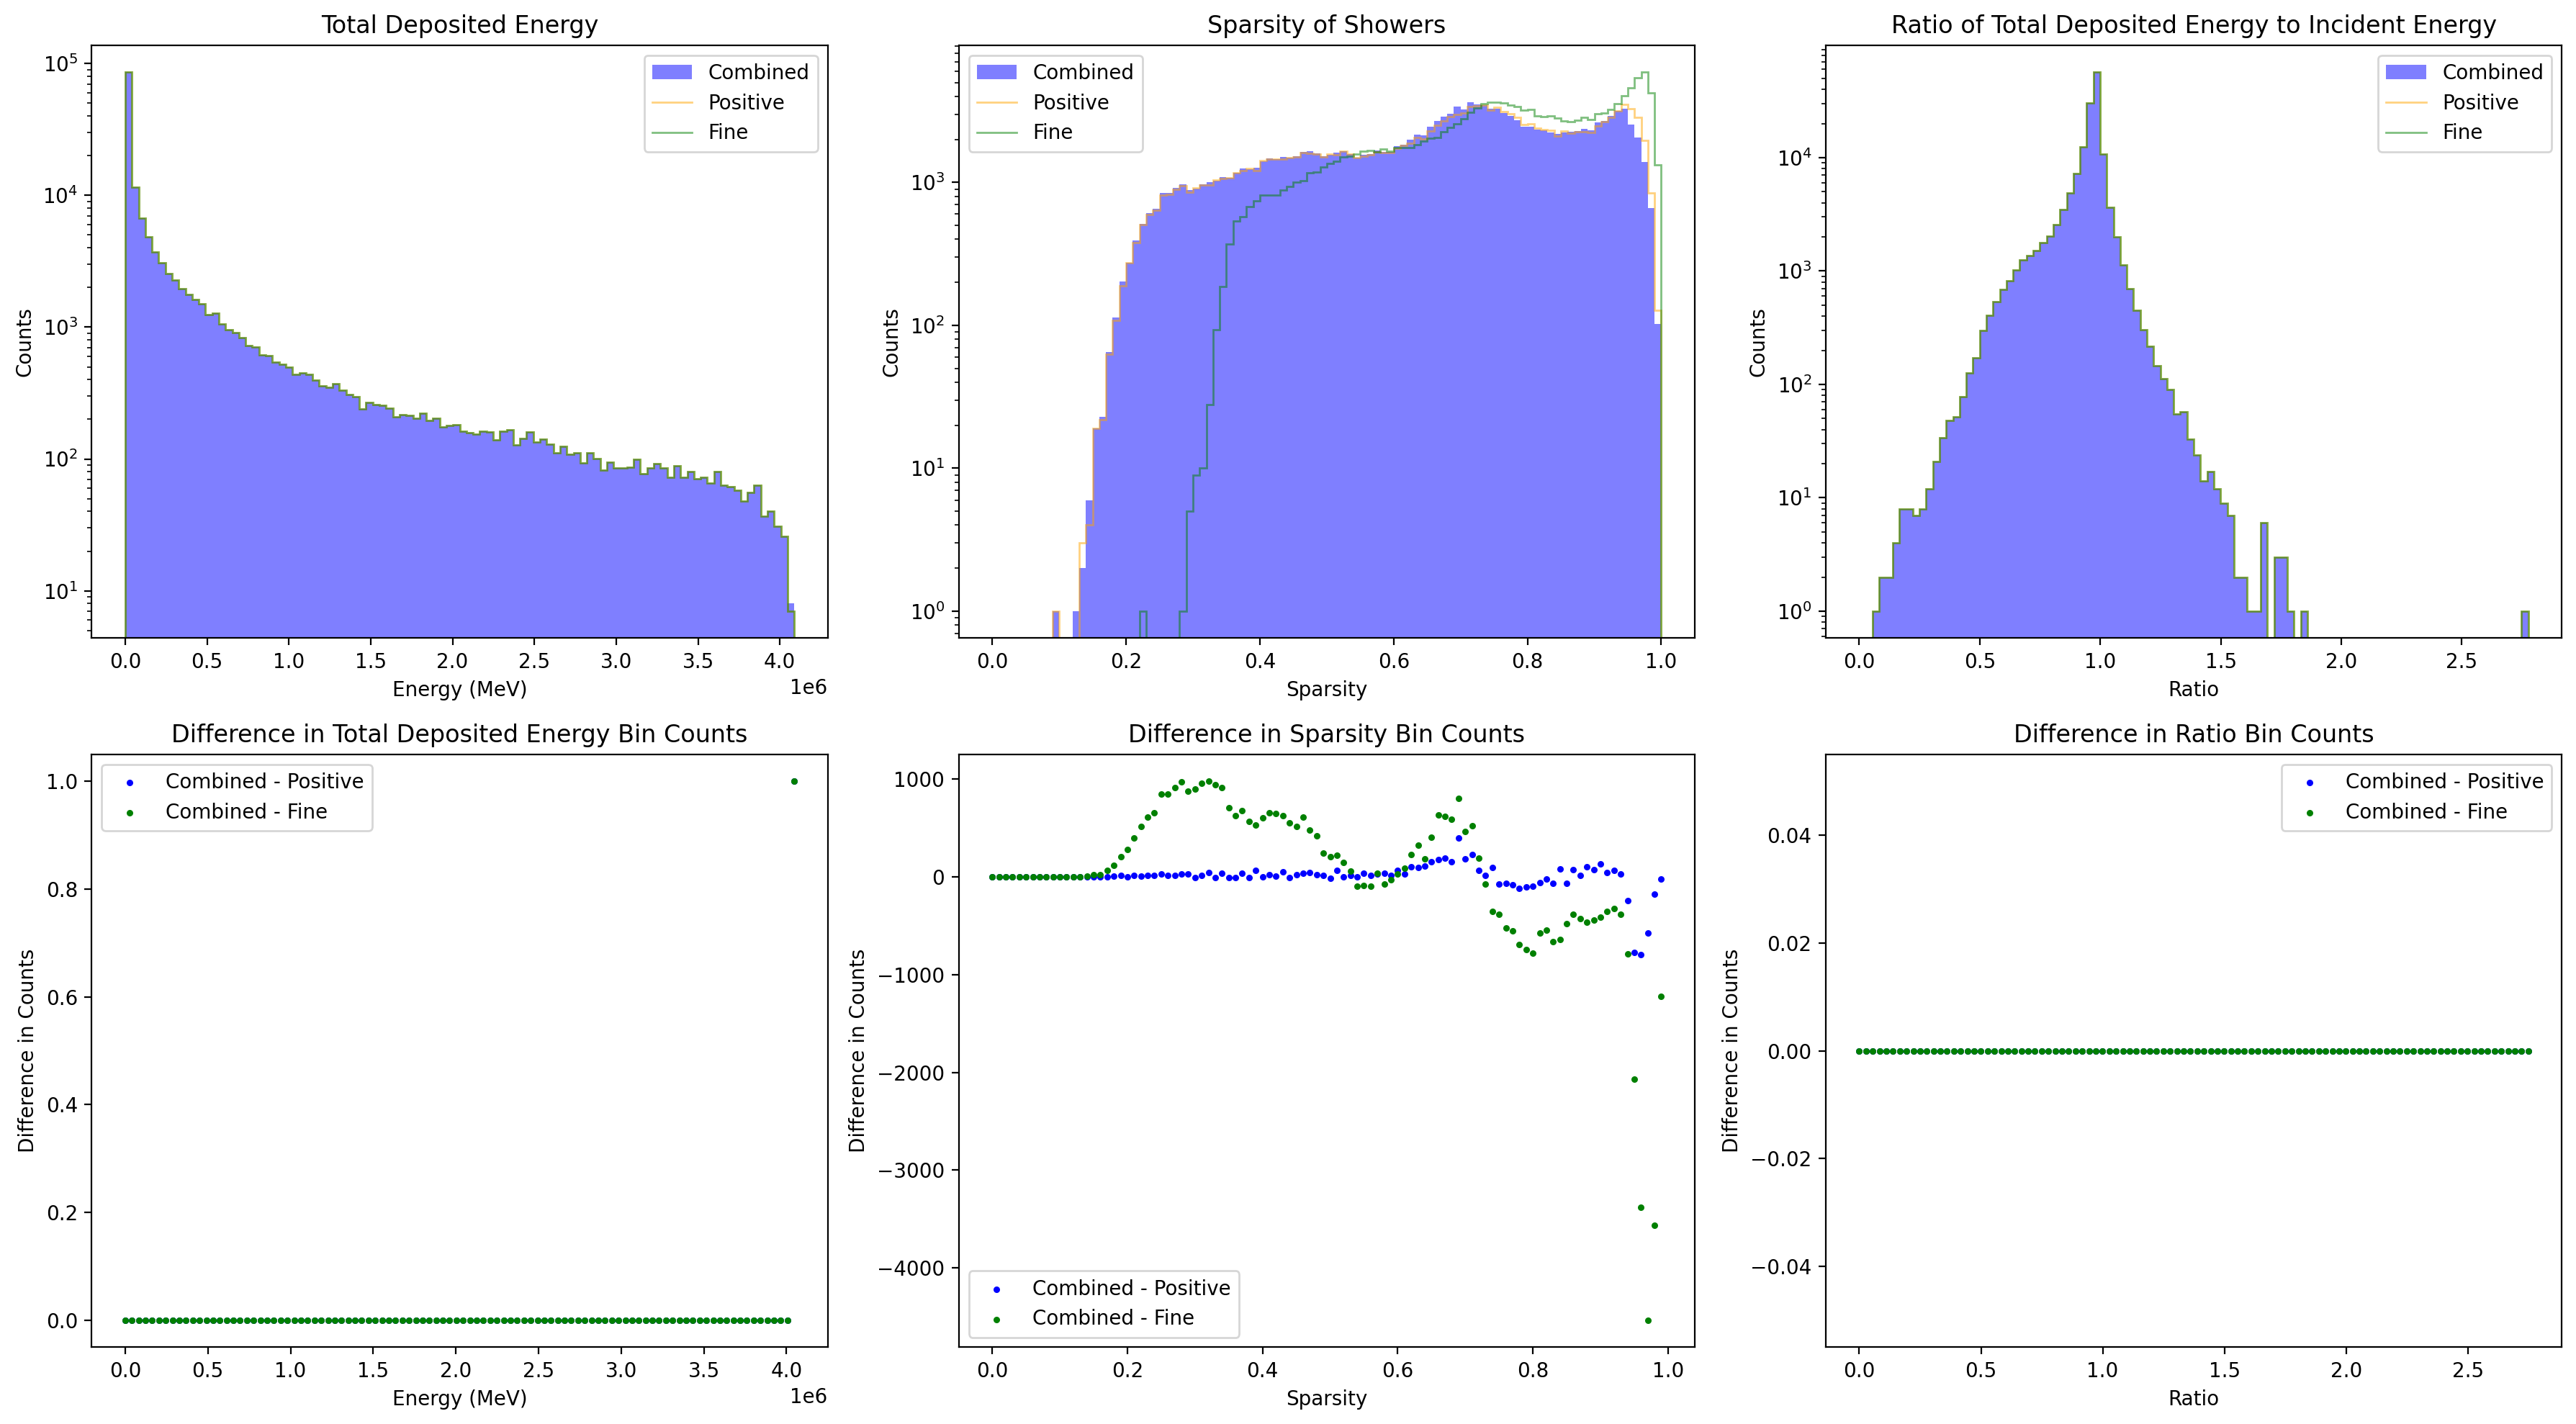

In [39]:
import importlib
import utils.data_exploration
importlib.reload(utils.data_exploration)
from utils.data_exploration import overall_plots
from utils.plots import vae_plots
file_name_combined = '/fast_scratch_1/caloqvae/data/atlas_july31_cat/eta_000/eta_000_regular_binning/dataset_combined_cat.hdf5'
with h5py.File(file_name_combined, 'r') as f:
    showers = torch.tensor(f['showers'][:])
    incident_energy = torch.tensor(f['incident_energy'][:])
file_name_positive = '/fast_scratch_1/caloqvae/data/atlas_july31_cat/eta_000/eta_000_regular_binning/dataset_positive_cat.hdf5'
with h5py.File(file_name_positive, 'r') as f:
    showers_positive = torch.tensor(f['showers'][:])
    incident_energy_positive = torch.tensor(f['incident_energy'][:])
file_name_fine = '/fast_scratch_1/caloqvae/data/atlas_july31_cat/eta_000/eta_000_regular_binning/dataset_fine_cat.hdf5'
os.path.exists(file_name_fine) or print(f"File {file_name_fine} does not exist.")
with h5py.File(file_name_fine, 'r') as f:
    showers_fine = torch.tensor(f['showers'][:])
    incident_energy_fine = torch.tensor(f['incident_energy'][:])
#vae_plots(cfg, incident_energy, showers, showers_positive, showers_fine)
overall_plots(incident_energy, incident_energy_positive, incident_energy_fine, showers, showers_positive, showers_fine)

/tmp/ipykernel_2145833/1349192235.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


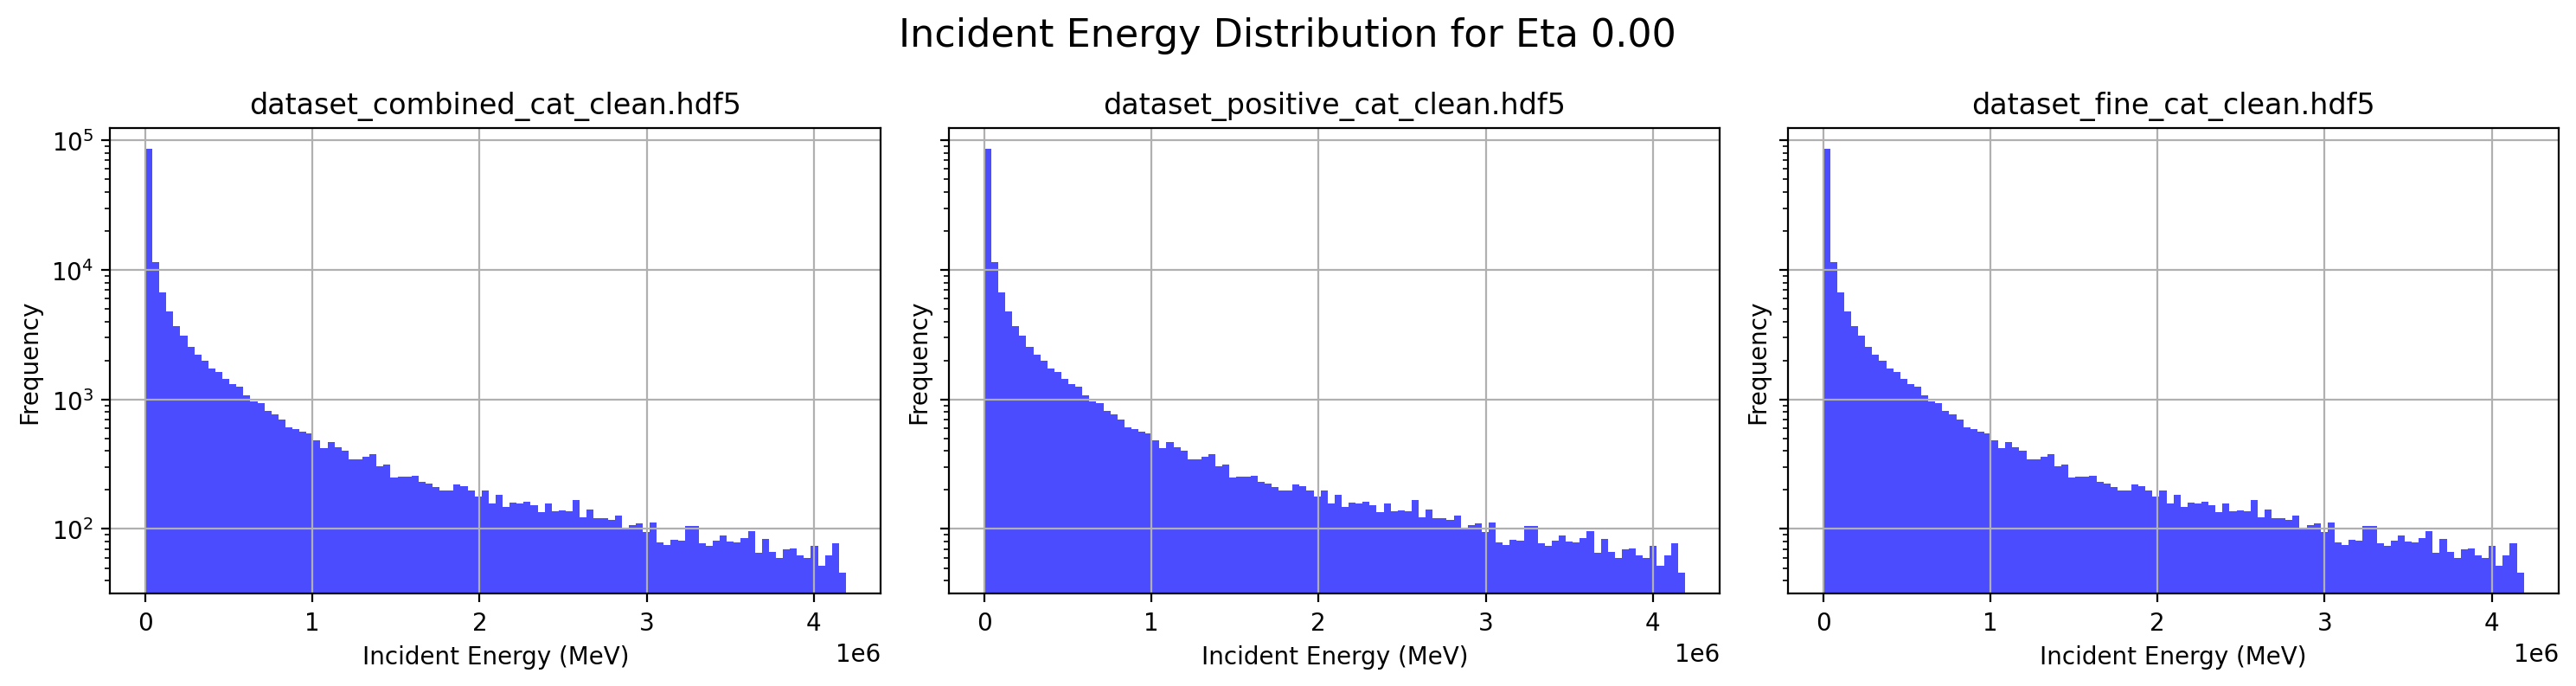

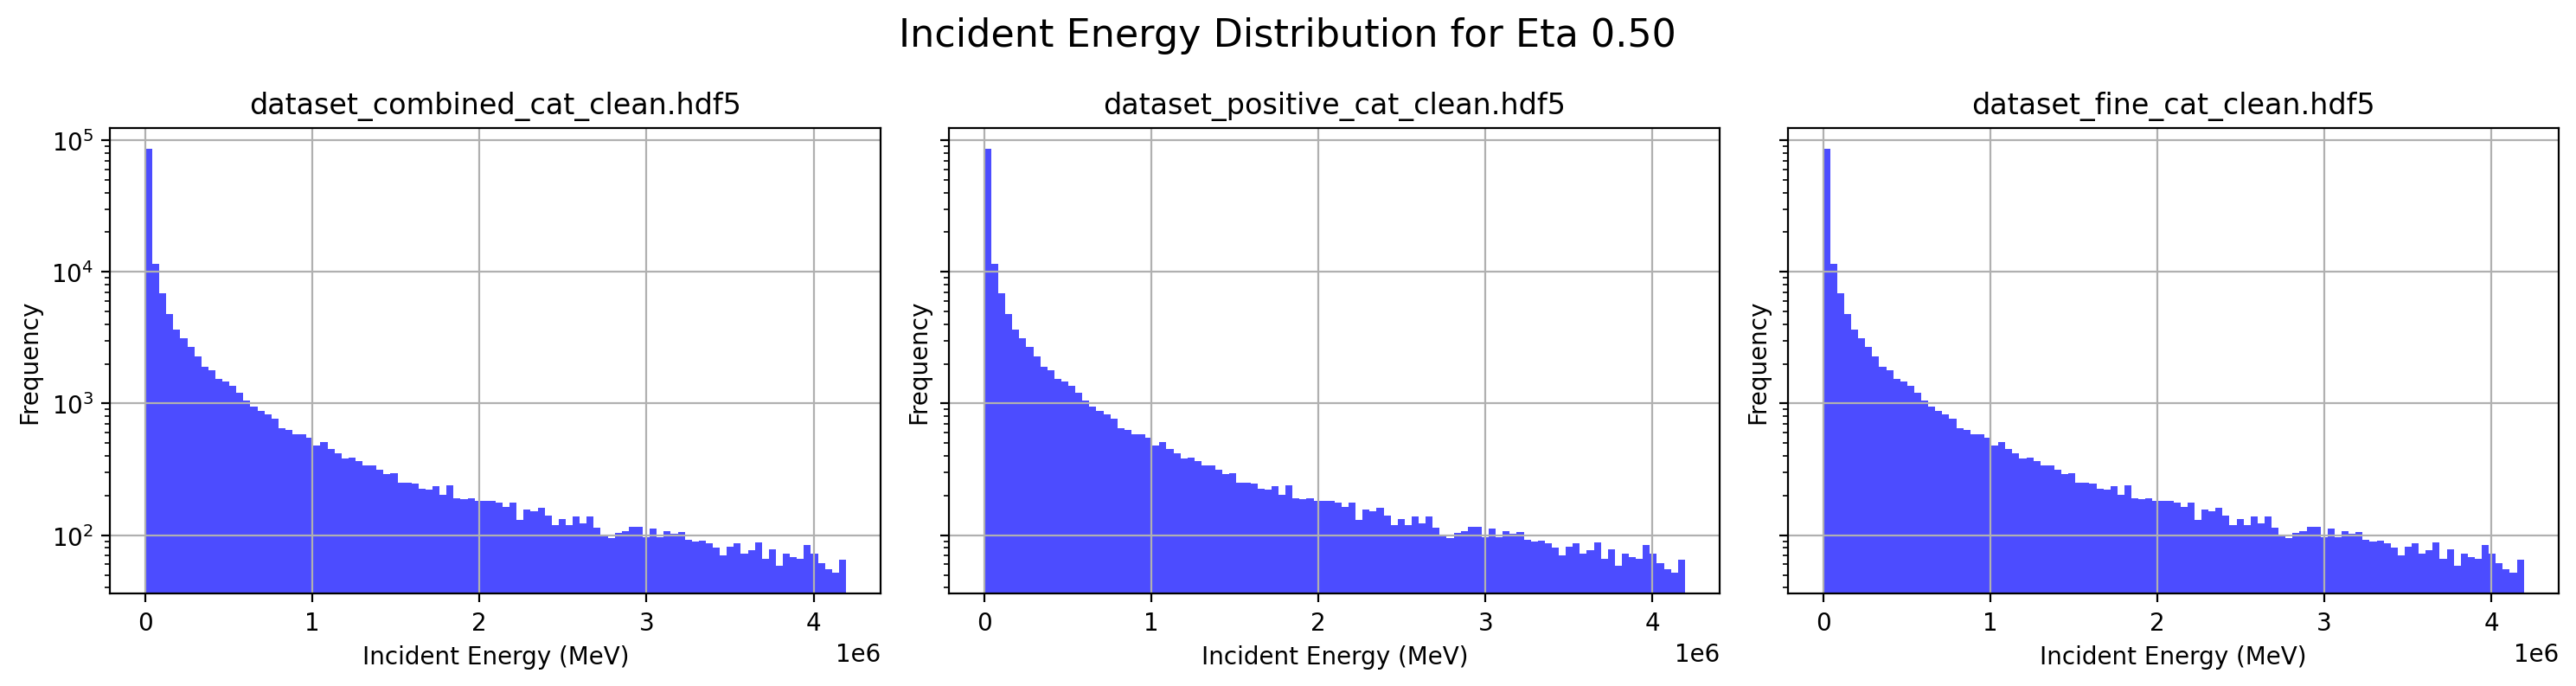

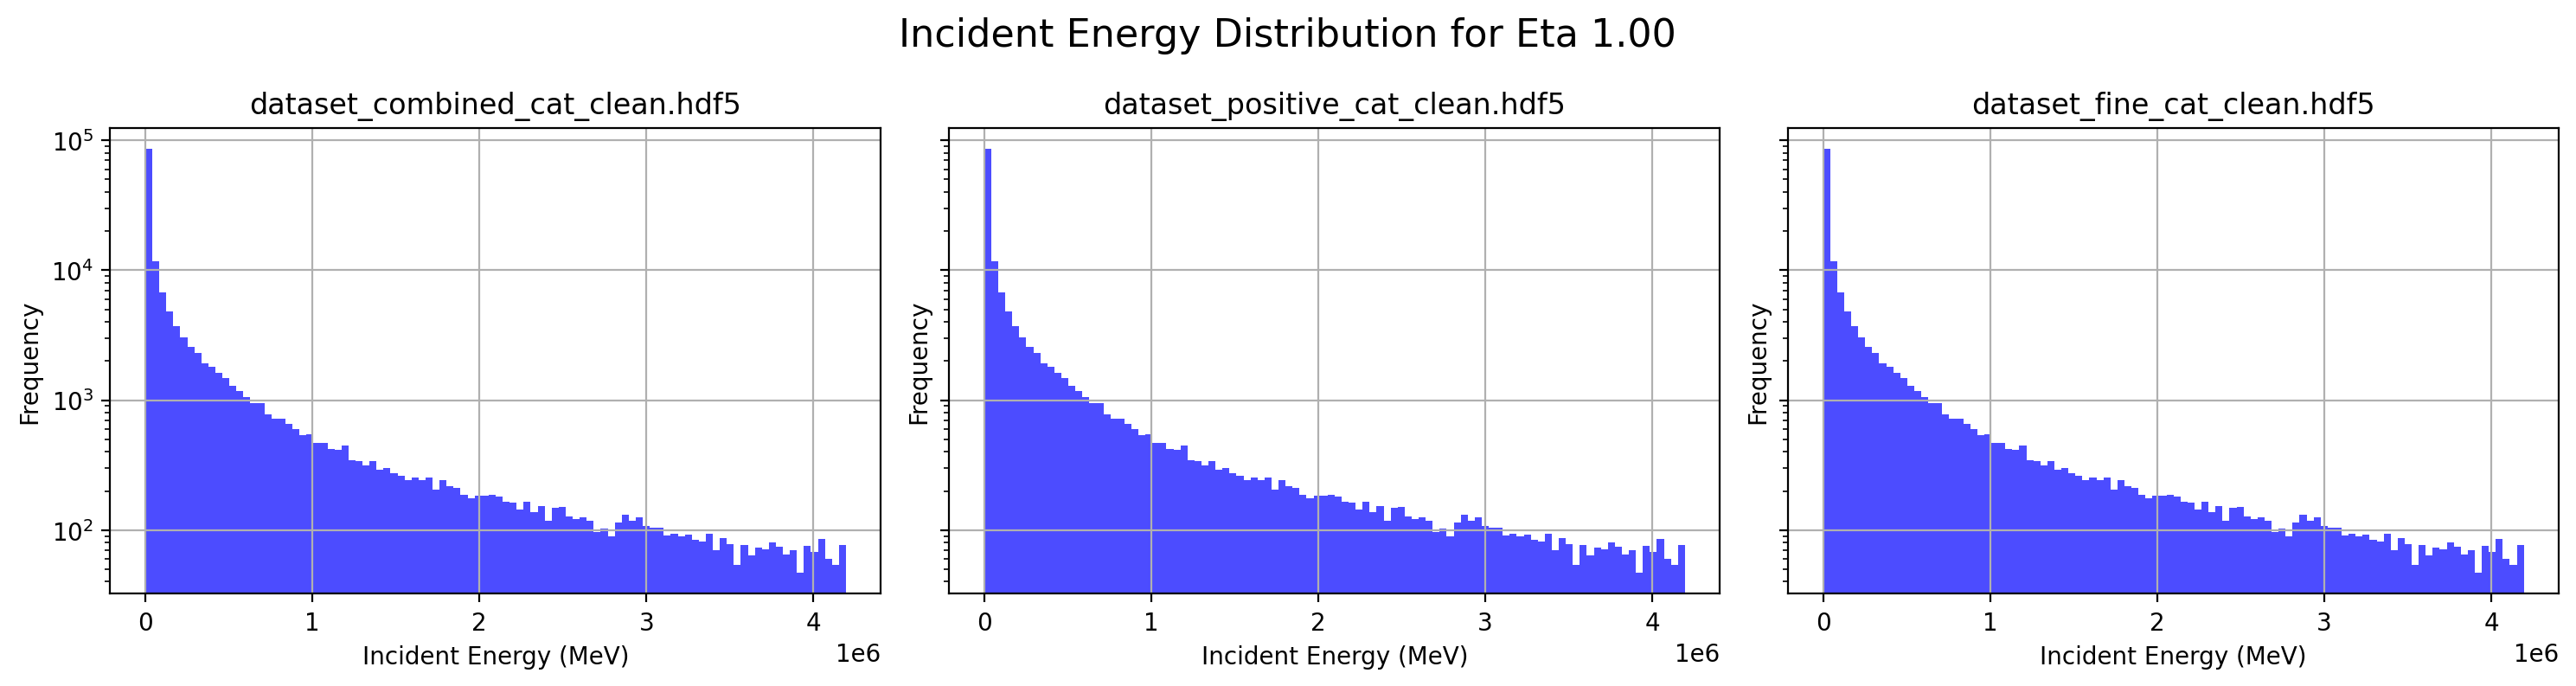

In [6]:
#plot distribution of incident energy, looping through all eta and file types
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
for eta in range(0, 135, 50)[:3]:
    file_names = ["dataset_combined_cat_clean.hdf5", "dataset_positive_cat_clean.hdf5", "dataset_fine_cat_clean.hdf5"]
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)
    for i, file_name in enumerate(file_names):
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r') as file:
            incident_energy = torch.from_numpy(file['incident_energies'][:]).squeeze()
        axs[i].hist(incident_energy.numpy(), bins=100, alpha=0.7, color='blue')
        axs[i].set_title(f'{file_name}')
        axs[i].set_xlabel('Incident Energy (MeV)')
        axs[i].set_ylabel('Frequency')
        axs[i].set_yscale('log')
        # axs[i].set_xscale('log')
        axs[i].grid(True)
    fig.suptitle(f'Incident Energy Distribution for Eta {eta/100.0:.2f}', fontsize=16)

    fig.tight_layout()

/tmp/ipykernel_2795379/794763299.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2795379/794763299.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


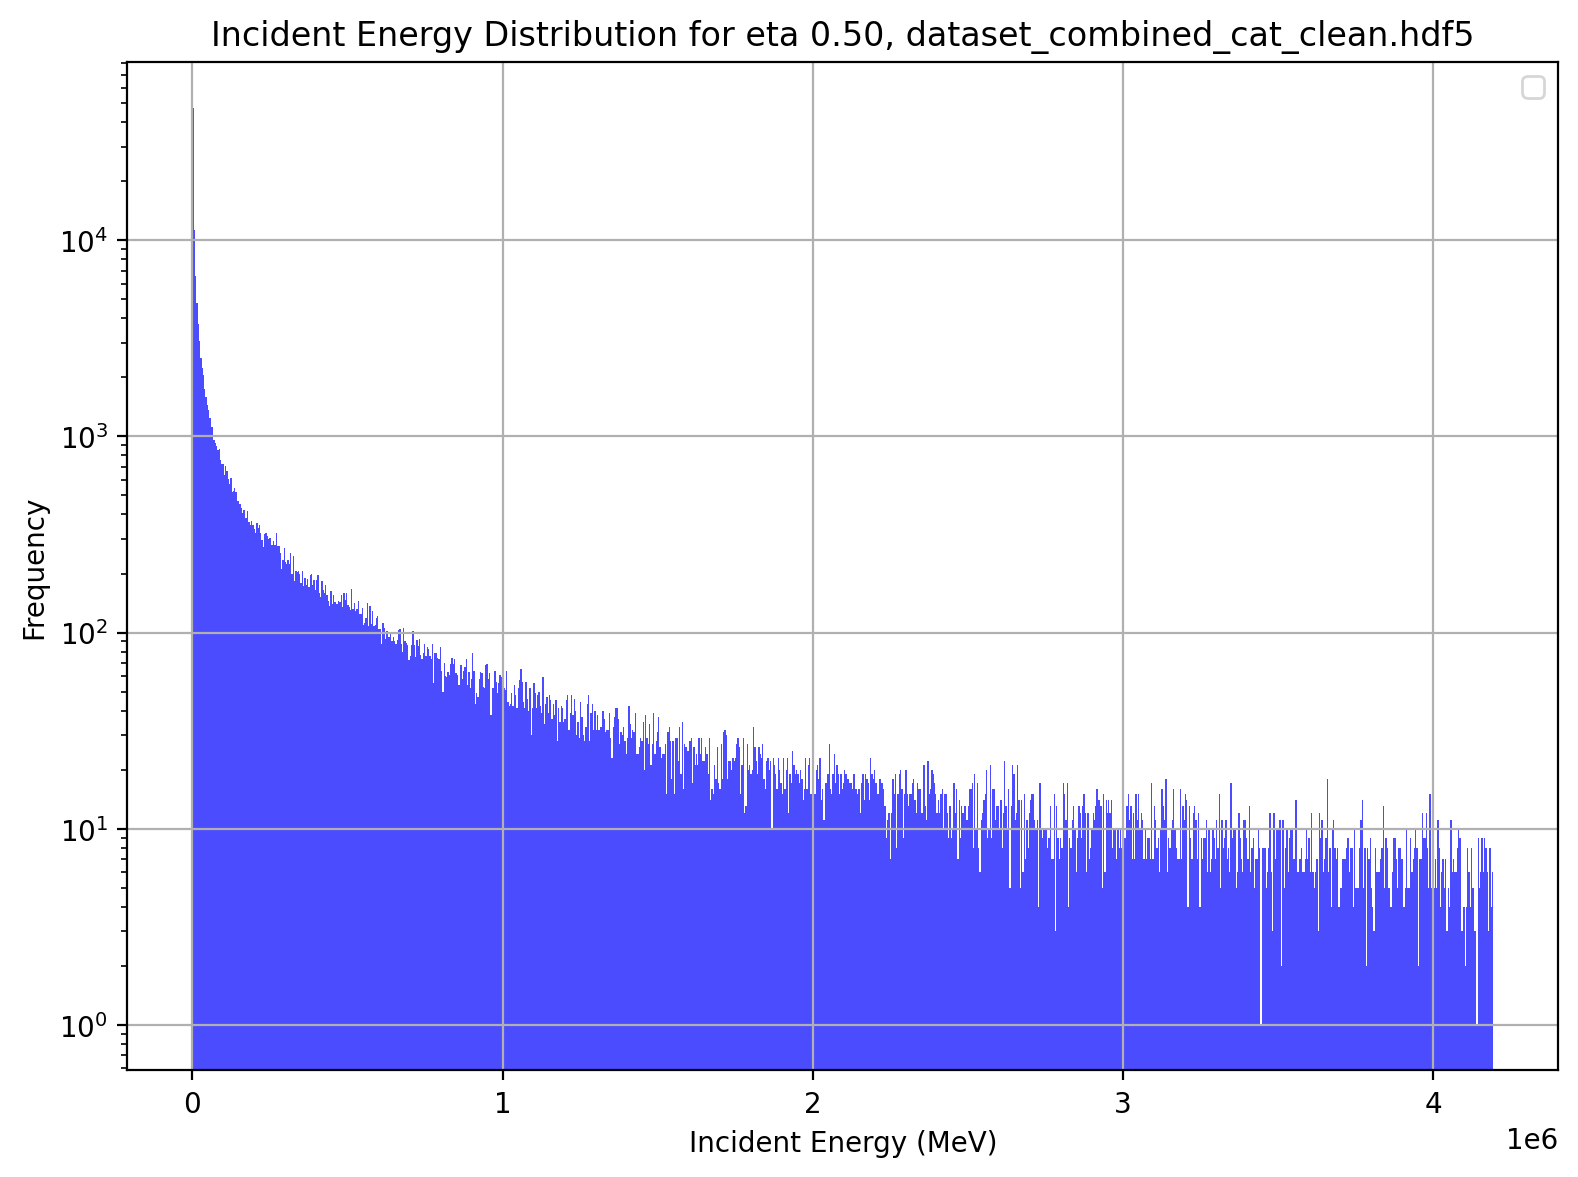

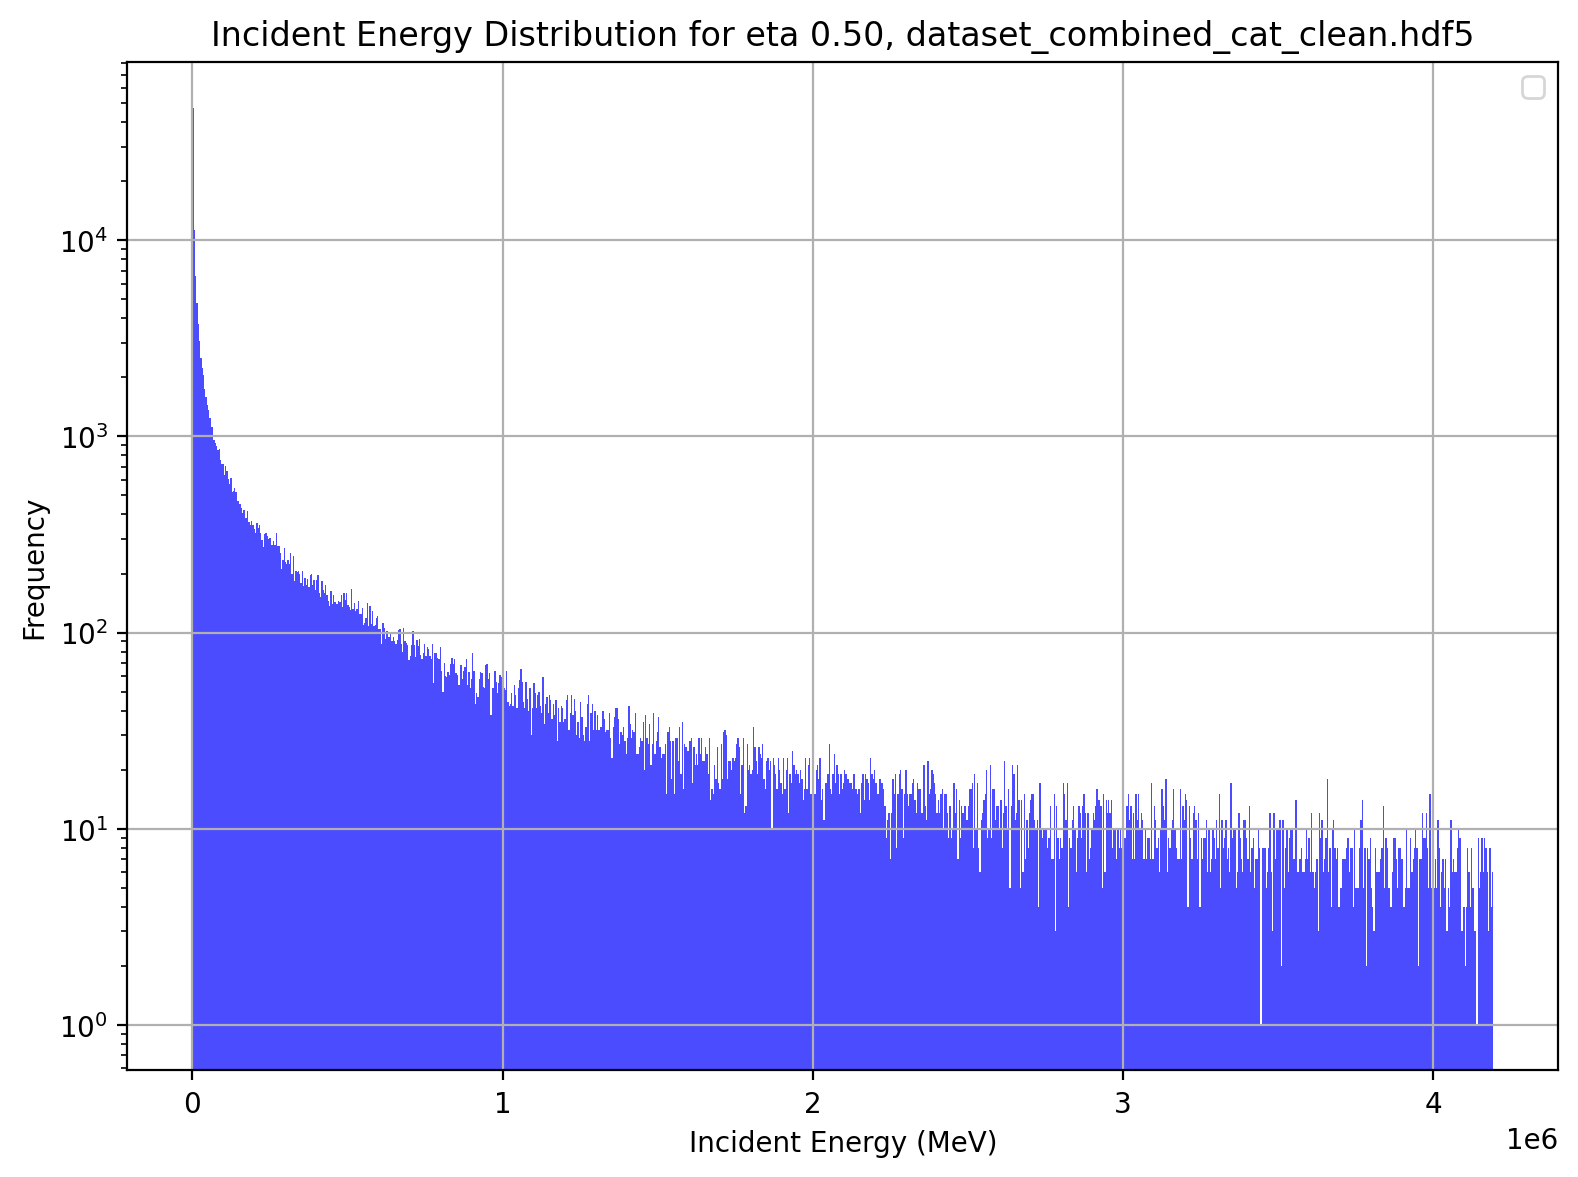

In [25]:
# examine incidence energy distribution for one file
eta = 50
file_name = f'/fast_scratch_1/caloqvae/data/atlas_july31_cat/eta_{eta:03d}/eta_{eta:03d}_regular_binning/dataset_combined_cat_clean.hdf5'
with h5py.File(file_name, 'r') as file:
    incident_energy = torch.from_numpy(file['incident_energies'][:]).squeeze()
plt.figure(figsize=(8, 6))
plt.hist(incident_energy.numpy(), bins=1000, alpha=0.7, color='blue')
plt.title(f'Incident Energy Distribution for eta {eta/100:.2f}, {file_name.split("/")[-1]}')
plt.xlabel('Incident Energy (MeV)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.xscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
# # cut off incidence energies greater than 10^5 MeV
# incident_energy = incident_energy[incident_energy < 1e5]
plt.figure(figsize=(8, 6))
plt.hist(incident_energy.numpy(), bins=1000, alpha=0.7, color='blue')
plt.title(f'Incident Energy Distribution for eta {eta/100:.2f}, {file_name.split("/")[-1]}')
plt.xlabel('Incident Energy (MeV)')
plt.ylabel('Frequency')
plt.yscale('log')
# plt.xscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [ ]:
# Plot distribution of total deposited energy per layer for combined, positive, and fine datasets across all eta
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
layer_cell_count = 14*24
num_relevant_layers = 5
for eta in range(0, 135, 5)[:1]:
    print(f"Processing eta {eta}")
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    fig, ax = plt.subplots(figsize=(10, 6))
    layer_fig, layer_ax = plt.subplots(2, 3, figsize=(18, 12))

    colors = ['blue', 'orange', 'green']
    histep = ["stepfilled", "step", "step"]
    histograms = []
    for i, file_name in enumerate(file_names):
        file = h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r')
        showers = torch.from_numpy(file['showers'][:])
        total_deposited_energy = showers.sum(dim=1)
        ax.hist(total_deposited_energy.numpy(), bins=30, alpha=0.7, color=colors[i], label=file_name.split('_')[1], histtype=histep[i])
        histogram, bin_edges = np.histogram(total_deposited_energy.numpy(), bins=100)
        histograms.append((histogram, bin_edges))

        ax.legend()    
        ax.set_xlabel('Total Deposited Energy (MeV)')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.set_title(f'Total Deposited Energy Distribution for Eta {eta/100.0}')
        ax.grid(True)

        for layer in range(num_relevant_layers):
            idx = layer * layer_cell_count
            layer_data = showers[:, idx:idx + layer_cell_count]
            total_layer_energy = layer_data.sum(dim=1)
            layer_ax[layer // 3, layer % 3].hist(total_layer_energy.numpy(), bins=30, alpha=0.7, color=colors[i], label=file_name.split('_')[1], histtype=histep[i])
            layer_ax[layer // 3, layer % 3].set_xlabel('Total Layer Energy (MeV)')
            layer_ax[layer // 3, layer % 3].set_ylabel('Frequency')
            layer_ax[layer // 3, layer % 3].set_yscale('log')
            layer_ax[layer // 3, layer % 3].grid(True)
            layer_ax[layer // 3, layer % 3].legend()
    layer_fig.tight_layout()
    fig.tight_layout()
    bin_edges = histograms[0][1]
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.figure(figsize=(10, 6))
    plt.scatter(bin_centers, histograms[0][0] - histograms[1][0], label='Combined - Positive', color='blue')
    plt.figure(figsize=(10, 6))
    plt.scatter(bin_centers, histograms[0][0] - histograms[2][0], label='Combined - Fine', color='orange')
    plt.show()

In [ ]:
# Check if incident energies are identical for each eta in original datasets
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
for eta in range(0, 135, 5):
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    incident_energies = []
    showers_list = []
    for file_name in file_names:
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r') as f:
            incident_energy = torch.from_numpy(f['incident_energy'][:])
            incident_energies.append(incident_energy)
            showers = torch.from_numpy(f['showers'][:]).sum(dim=1)
            showers_list.append(showers)

    
    # Check if all incident energies are the same
    if all(torch.equal(incident_energies[0], ie) for ie in incident_energies):
        print(f"Incident energies are identical for eta {eta}")
    else:
        print(f"Incident energies differ for eta {eta}")
    # Count differences in showers
    combined_showers = showers_list[0]
    positive_showers = showers_list[1]
    #fine_showers = showers_list[2]
    shower_differences_positive = (combined_showers != positive_showers).sum().nonzero().shape[0]
    #shower_differences_fine = (combined_showers != fine_showers).sum(dim=1).nonzero().shape[0]
    print(f"Number of differences in showers between positive and combined for eta {eta}: {shower_differences_positive}")
    #print(f"Number of differences in showers between fine and combined for eta {eta}: {shower_differences_fine}")


In [ ]:
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
num_differences_eta_positive = []
num_differences_eta_fine = []
etas = list(range(0, 135, 5))
for eta in etas:
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    showers_list = []
    for file_name in file_names:
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r') as f:
            showers = torch.from_numpy(f['showers'][:])
            #mask out negative values in showers
            showers[showers < 0] = 0
            showers = showers.sum(dim=1)  # Sum across layers
            showers_list.append(showers)

    combined_showers = showers_list[0]
    positive_showers = showers_list[1]
    fine_showers = showers_list[2]

    # try masking out negative values in combined showers
    combined_showers[combined_showers < 0] = 0
    # Compare shower sums: combined vs positive
    print(combined_showers[:5], positive_showers[:5])
    diff_mask_pos = combined_showers != positive_showers
    num_differences_pos = diff_mask_pos.sum().item()
    num_differences_eta_positive.append(num_differences_pos)

    # Compare shower sums: combined vs fine
    diff_mask_fine = combined_showers != fine_showers
    num_differences_fine = diff_mask_fine.sum().item()
    num_differences_eta_fine.append(num_differences_fine)

# Plot number of differences across all eta
plt.figure(figsize=(12, 6))
bar_width = 2
eta_centres = np.array(etas)
plt.bar(eta_centres - bar_width/2, num_differences_eta_positive, width=bar_width, color='blue', alpha=0.7, label='Combined vs Positive')
plt.bar(eta_centres + bar_width/2, num_differences_eta_fine, width=bar_width, color='orange', alpha=0.7, label='Combined vs Fine')
plt.xlabel('Eta', fontsize=14)
plt.ylabel('Number of Differences in Shower Sums', fontsize=14)
plt.title('Number of Differences in Shower Sums between Datasets', fontsize=16)
plt.xticks(eta_centres, rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


tensor([1.0890e+04, 1.4819e+05, 2.2201e+05, 1.4634e+03, 1.5713e+06],
       dtype=torch.float64) tensor([1.0890e+04, 1.4819e+05, 2.2201e+05, 1.4634e+03, 1.5713e+06],
       dtype=torch.float64)
tensor([   582.5988,    606.2285, 492449.9151,    914.2028,   1678.3112],
       dtype=torch.float64) tensor([   582.5988,    606.2285, 492449.9153,    914.2028,   1678.3112],
       dtype=torch.float64)
tensor([   811.6288,   6752.5351, 342727.0362, 116149.0397,  29898.8468],
       dtype=torch.float64) tensor([   811.6288,   6752.5351, 342727.0355, 116149.0403,  29898.8463],
       dtype=torch.float64)
tensor([1.6949e+04, 3.6893e+05, 1.0088e+04, 3.1488e+02, 1.8623e+03],
       dtype=torch.float64) tensor([1.6949e+04, 3.6893e+05, 1.0088e+04, 3.1488e+02, 1.8623e+03],
       dtype=torch.float64)
tensor([5.5839e+05, 1.1597e+03, 8.3983e+05, 1.3805e+06, 1.2425e+05],
       dtype=torch.float64) tensor([5.5839e+05, 1.1597e+03, 8.3983e+05, 1.3805e+06, 1.2425e+05],
       dtype=torch.float64)
tensor([40

KeyboardInterrupt: 

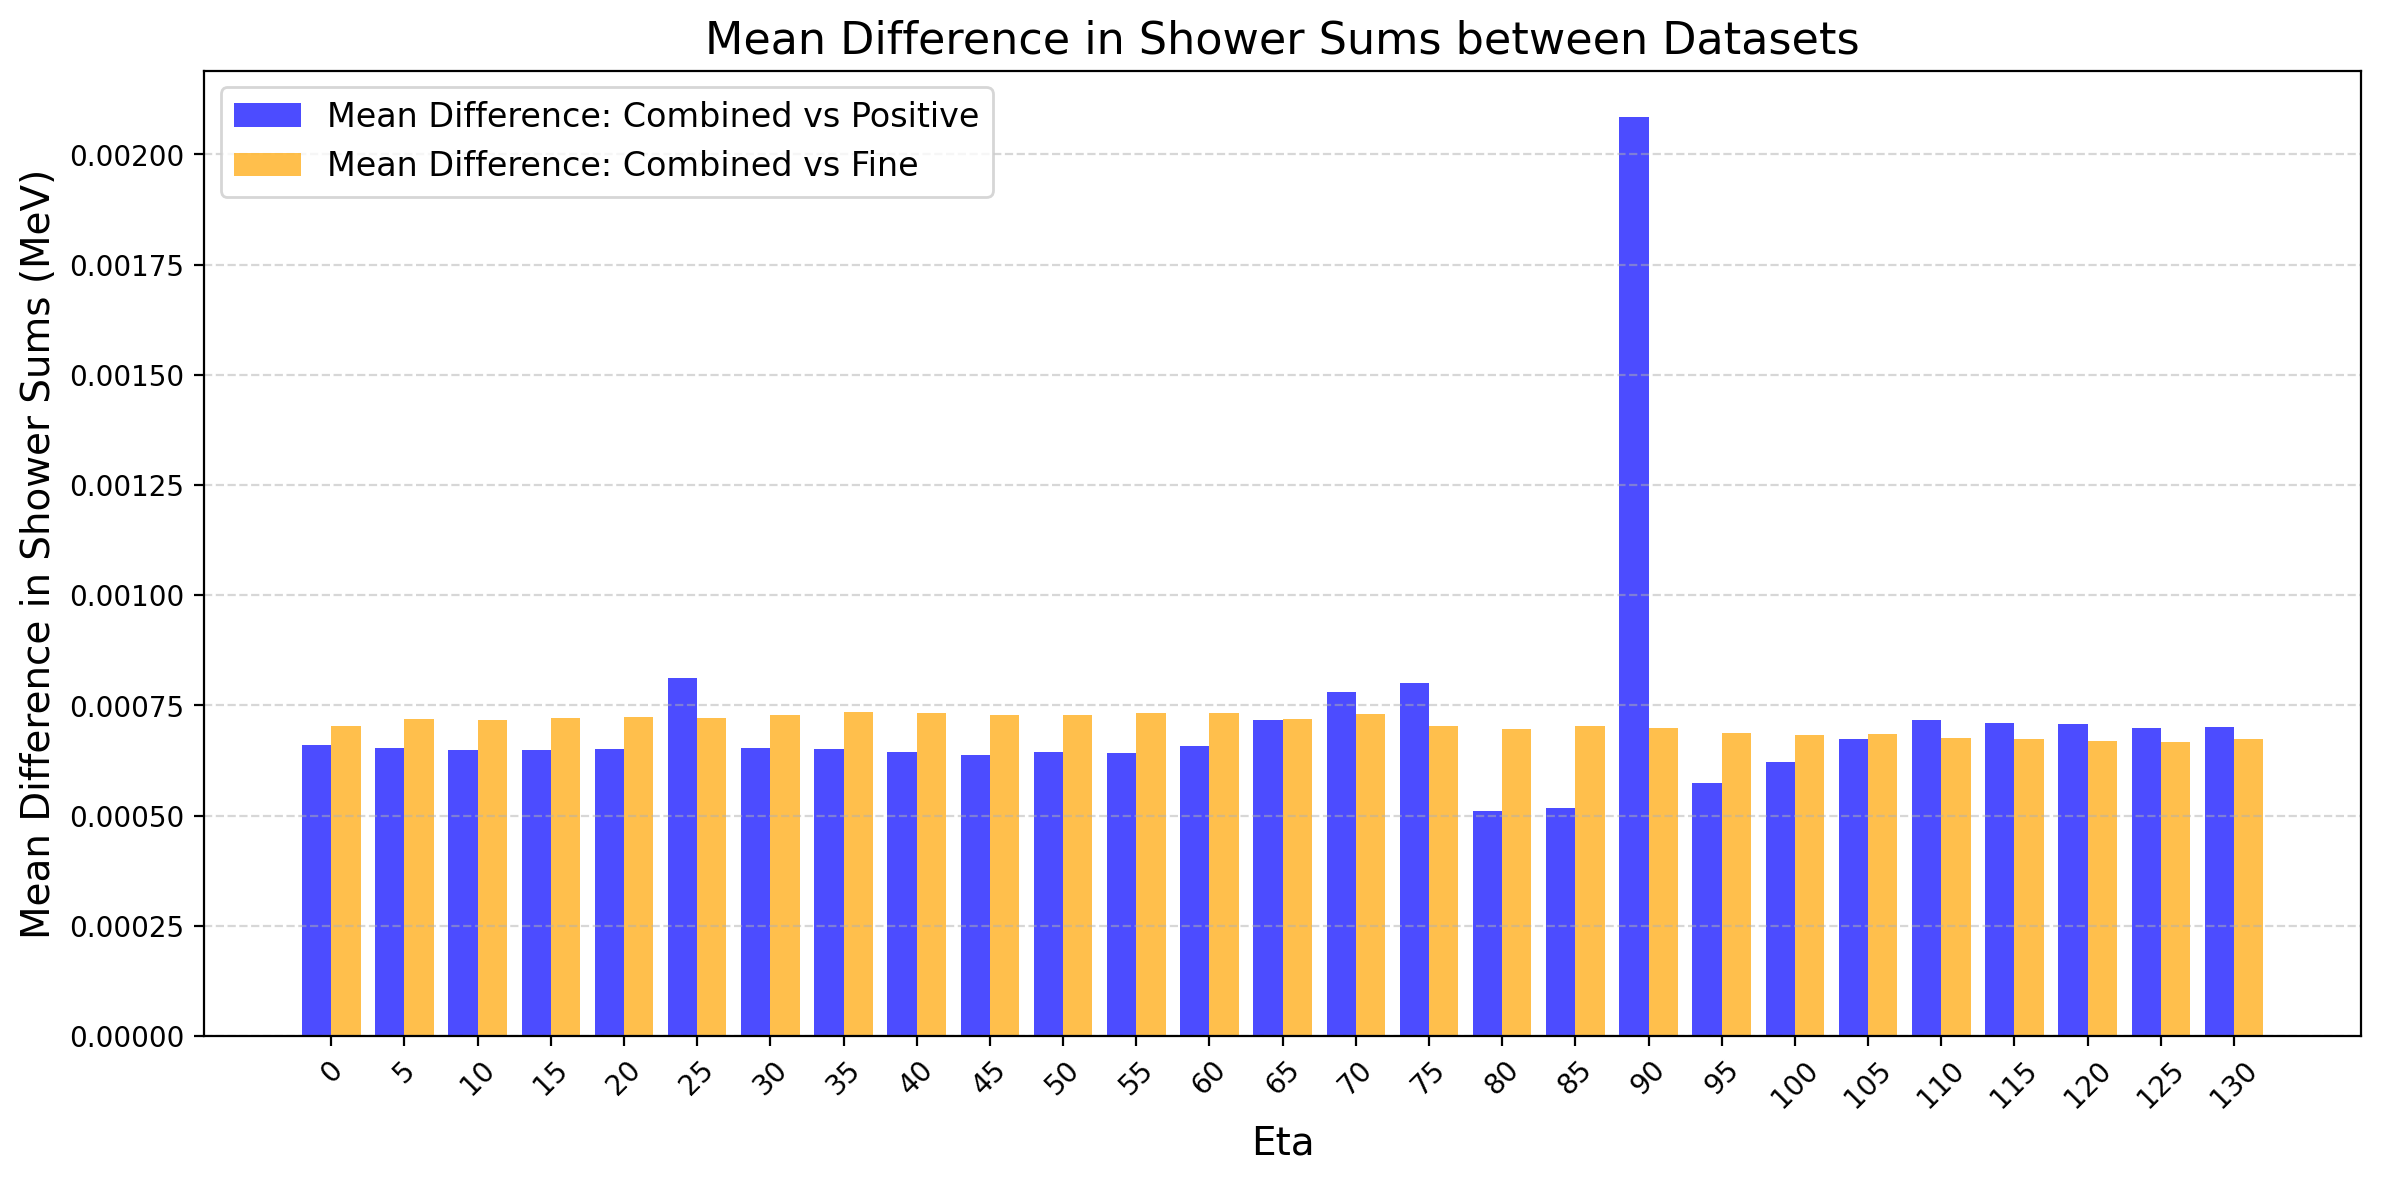

In [4]:
# plot mean difference in shower sums between positive vs combined and fine vs combined across all eta
etas = list(range(0, 135, 5))
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"
mean_diff_positive_list = []
mean_diff_fine_list = []
for eta in etas:
    file_names = ["dataset_combined_cat.hdf5", "dataset_positive_cat.hdf5", "dataset_fine_cat.hdf5"]
    showers_list = []
    for file_name in file_names:
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", 'r') as f:
            showers = torch.from_numpy(f['showers'][:]).sum(dim=1)
            showers_list.append(showers)

    combined_showers = showers_list[0]
    positive_showers = showers_list[1]
    fine_showers = showers_list[2]

    # Calculate mean difference: combined vs positive
    mean_diff_pos = (combined_showers - positive_showers).abs().mean().item()
    mean_diff_positive_list.append(mean_diff_pos)

    # Calculate mean difference: fine vs combined
    mean_diff_fine = (fine_showers - combined_showers).abs().mean().item()
    mean_diff_fine_list.append(mean_diff_fine)
# Plot mean differences across all eta
plt.figure(figsize=(12, 6))
bar_width = 2
eta_centres = np.array(etas)
plt.bar(eta_centres - bar_width/2, mean_diff_positive_list, width=bar_width, color='blue', alpha=0.7, label='Mean Difference: Combined vs Positive')
plt.bar(eta_centres + bar_width/2, mean_diff_fine_list, width= bar_width, color='orange', alpha=0.7, label='Mean Difference: Combined vs Fine')
plt.xlabel('Eta', fontsize=14)
plt.ylabel('Mean Difference in Shower Sums (MeV)', fontsize=14)
plt.title('Mean Difference in Shower Sums between Datasets', fontsize=16)
plt.xticks(eta_centres, rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Processing etas: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [04:39<00:00, 10.34s/it]


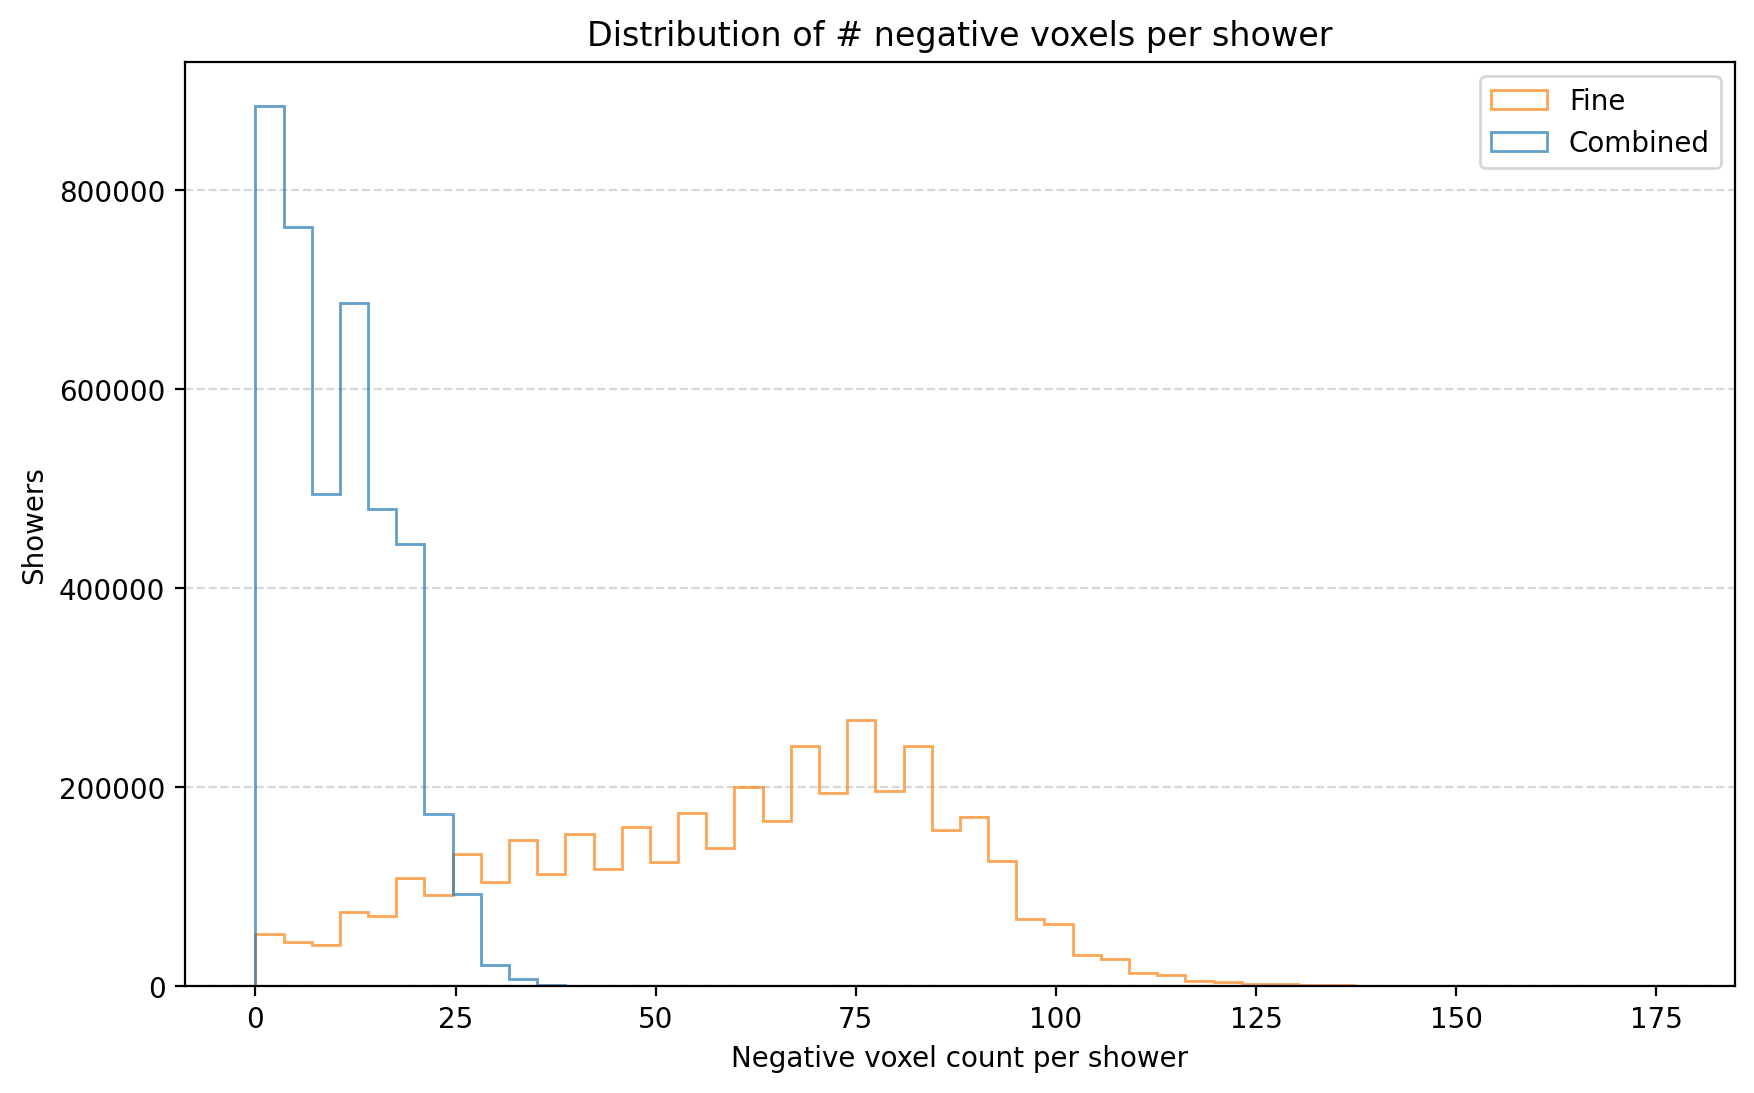

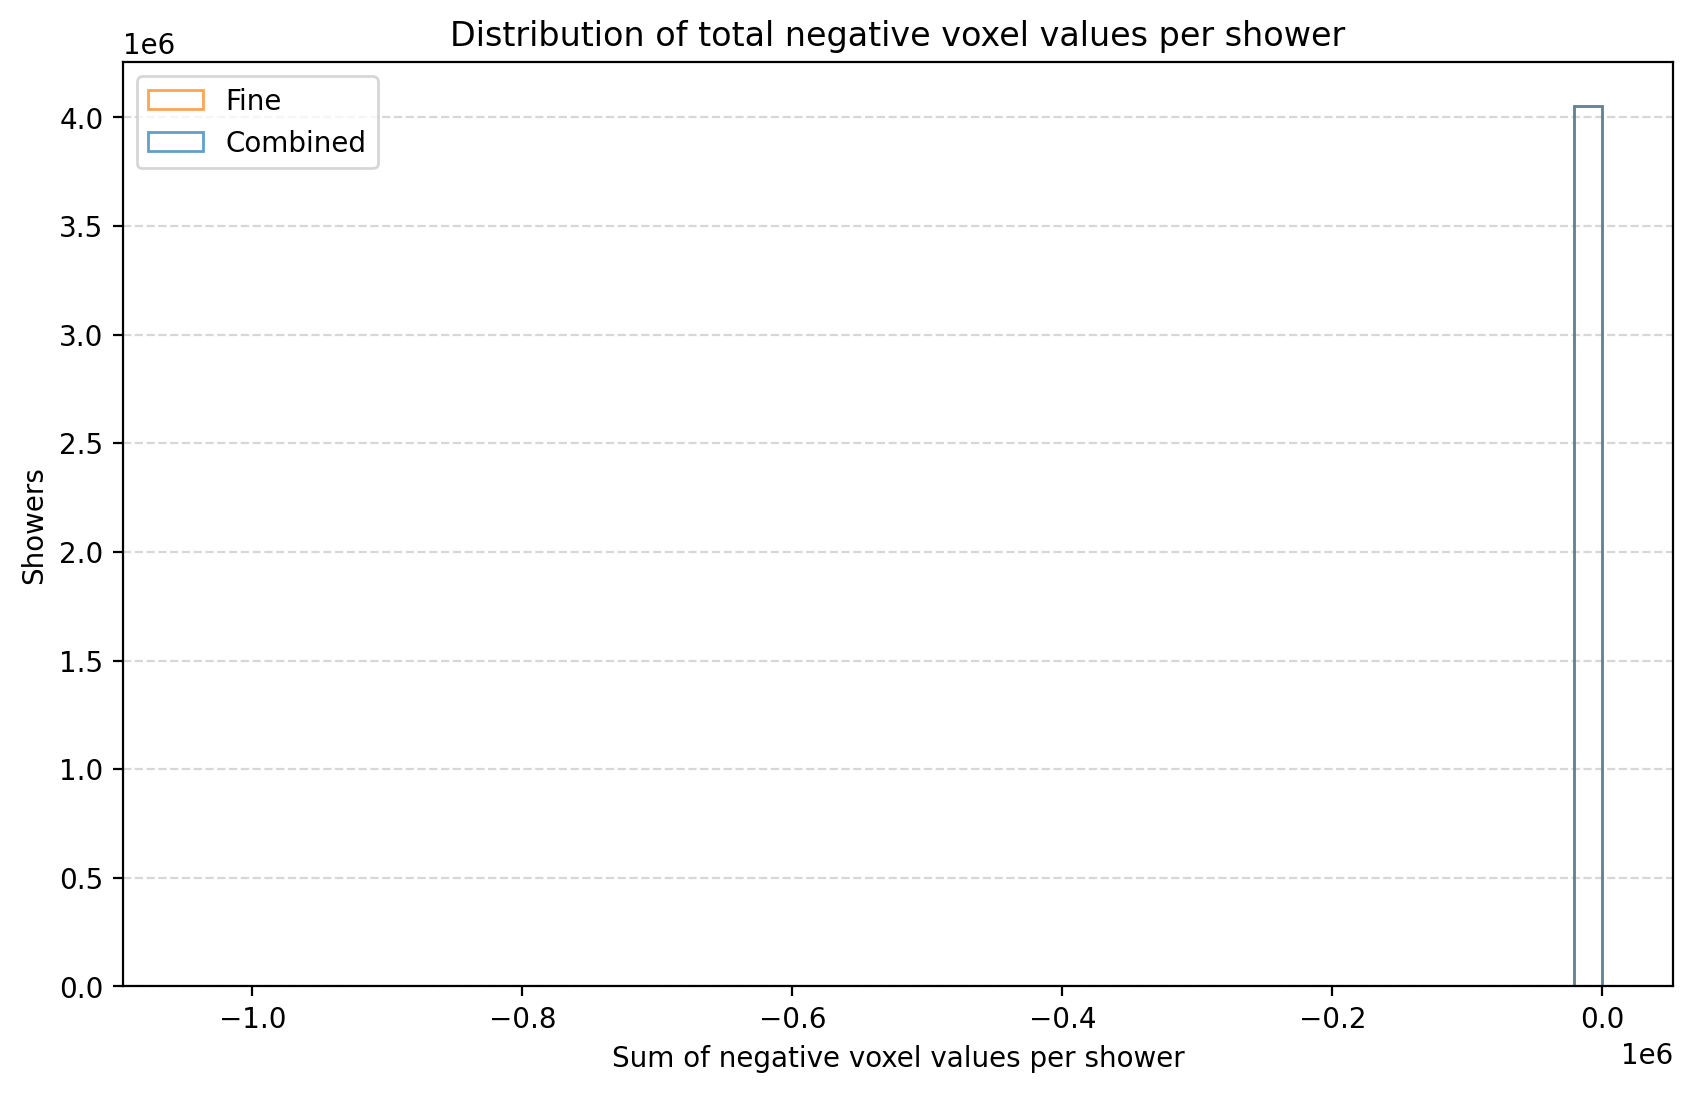


=== dataset_combined_cat.hdf5 ===
Mean negative voxels per shower: 10.42
Median negative voxels per shower: 10.00
Mean sum of negative voxels: -8.5170
Median sum of negative voxels: -3.6292

=== dataset_fine_cat.hdf5 ===
Mean negative voxels per shower: 59.26
Median negative voxels per shower: 63.00
Mean sum of negative voxels: -42.7516
Median sum of negative voxels: -25.7522

Sample of negative voxel values:
[-6.38017140e-05 -1.37834570e+00 -9.12705701e-02 -1.41716163e-01
 -2.49360252e-01 -5.24081447e-01 -1.27313817e-02 -6.20895253e-01
 -1.12159078e+00 -8.20362190e-02 -1.29574188e-01 -1.09259523e-03
 -1.54908519e-03 -2.23700895e-01 -1.42570972e+00 -2.49604258e+00
 -1.49801101e-03 -9.08515900e-01 -1.47530648e-01 -2.30922282e+00]


In [24]:
import torch
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

etas = list(range(0, 135, 5))
base_dir = "/fast_scratch_1/caloqvae/data/atlas_july31_cat"

# Store full distributions instead of just means
negative_counts_all = {k: [] for k in ["dataset_combined_cat.hdf5", "dataset_fine_cat.hdf5"]}
negative_sums_all = {k: [] for k in ["dataset_combined_cat.hdf5", "dataset_fine_cat.hdf5"]}
negative_values_sample = []

for eta in tqdm(etas, desc="Processing etas"):
    for file_name in ["dataset_combined_cat.hdf5", "dataset_fine_cat.hdf5"]:
        with h5py.File(f"{base_dir}/eta_{eta:03d}/eta_{eta:03d}_regular_binning/{file_name}", "r") as f:
            showers = torch.from_numpy(f["showers"][:])  # shape: (n_events, ...)

        # mask for negative voxels
        negative_mask = showers < 0

        # per-event counts and sums
        reduce_dims = tuple(range(1, showers.ndim))  # all dims except batch
        negative_counts_per_event = negative_mask.sum(dim=reduce_dims)  # counts
        negative_sum_per_event = (showers * negative_mask).sum(dim=reduce_dims)  # sum of values

        negative_counts_all[file_name].extend(negative_counts_per_event.tolist())
        negative_sums_all[file_name].extend(negative_sum_per_event.tolist())

        # store a small sample of the *actual voxel values*
        if len(negative_values_sample) < 5000:  # cap so it doesn’t blow up RAM
            negative_values_sample.extend(showers[negative_mask].tolist()[:5000 - len(negative_values_sample)])

# --- Histograms: counts ---
plt.figure(figsize=(10, 6))
plt.hist(
    [negative_counts_all["dataset_combined_cat.hdf5"],
     negative_counts_all["dataset_fine_cat.hdf5"]],
    bins=50,
    label=["Combined", "Fine"],
    alpha=0.7,
    histtype='step'
)
plt.ylabel("Showers")
plt.xlabel("Negative voxel count per shower")
plt.title("Distribution of # negative voxels per shower")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# --- Histograms: sums ---
plt.figure(figsize=(10, 6))
plt.hist(
    [negative_sums_all["dataset_combined_cat.hdf5"],
     negative_sums_all["dataset_fine_cat.hdf5"]],
    bins=50,
    label=["Combined", "Fine"],
    alpha=0.7,
    histtype='step'
)
plt.ylabel("Showers")
plt.xlabel("Sum of negative voxel values per shower")
plt.title("Distribution of total negative voxel values per shower")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# --- Print some stats ---
for file_name in negative_counts_all:
    print(f"\n=== {file_name} ===")
    counts = np.array(negative_counts_all[file_name])
    sums = np.array(negative_sums_all[file_name])
    print(f"Mean negative voxels per shower: {counts.mean():.2f}")
    print(f"Median negative voxels per shower: {np.median(counts):.2f}")
    print(f"Mean sum of negative voxels: {sums.mean():.4f}")
    print(f"Median sum of negative voxels: {np.median(sums):.4f}")

# --- Inspect sample of voxel values ---
print("\nSample of negative voxel values:")
print(np.random.choice(negative_values_sample, size=20, replace=False))


In [ ]:
self.evaluate_vae(self.data_mgr.test_loader, 0)

In [ ]:
import importlib
import utils.HighLevelFeatsAtlasReg
importlib.reload(utils.HighLevelFeatsAtlasReg)
from utils.HighLevelFeatsAtlasReg import HighLevelFeatures_ATLAS_regular as HLF2
import scripts.jet_metrics_atlas
importlib.reload(scripts.jet_metrics_atlas)
from scripts.jet_metrics_atlas import HepMetricsAtlas
importlib.reload(scripts.Jet_metrics)
from scripts.Jet_metrics import get_fpd_kpd_metrics

sample_sets = [
    (self.showers[0], 'Ground Truth'),
    (self.showers_recon[0], 'Reconstructions'),
    (self.showers_prior[0], 'Generated')
]
recon_HLF = HLF2("electron", filename=self._config.data.binning_path)
recon_HLF.Einc = self.incident_energy
gt_HLF = HLF2("electron", filename=self._config.data.binning_path)


ATLAS_hep = HepMetricsAtlas(self)
get_fpd_kpd_metrics(self.showers, self.showers_recon, False, recon_HLF, gt_HLF, if_Atlas=True)

In [ ]:
test_engine = setup_model(cfg)

In [ ]:
self.evaluate_vae(self.data_mgr.test_loader, 0)
test_engine.evaluate_ae(self.data_mgr.val_loader, 0)

In [ ]:
self.evaluate_vae(self.data_mgr.val_loader, 0)

In [ ]:
self.evaluate_vae(self.data_mgr.test_loader, 0)

In [ ]:
HLF_020 = HLF2("electron", filename=test_engine._config.data.binning_path)
HLF_035 = HLF2("electron", filename=self._config.data.binning_path)
HLF_020.Einc = test_engine.incident_energy

get_fpd_kpd_metrics(test_engine.showers, self.showers, False, HLF_020, HLF_035, if_Atlas=True)

In [ ]:
importlib.reload(scripts.jet_metrics_atlas)
importlib.reload(scripts.Jet_metrics)
#test_metrics = get_fpd_kpd_metrics(self.showers, self.showers_recon, False, recon_HLF, gt_HLF, if_Atlas=True)
ATLAS_hep = HepMetricsAtlas(self)
ATLAS_hep.run(self, 0)

In [ ]:
importlib.reload(scripts.jet_metrics_atlas)
from scripts.jet_metrics_atlas import main_run
main_run()

In [ ]:
# self.evaluate(self.data_mgr.test_loader, 0)

In [ ]:
# vae_plots(self.incident_energy, self.showers, self.showers_recon)

In [ ]:
self.model.train()
# with torch.no_grad():
x,x0 = next(iter(self.data_mgr.train_loader))
#reduce batch size to 1 for testing
x = x
x0 = x0
print("batch size:", x.shape[0])
print("total number of parameters:", np.log(sum(p.numel() for p in self.model.parameters() if p.requires_grad))) #e^19 for large model
print("memory before forward pass:", torch.cuda.memory_allocated(self.device)/1e6, "MB")
x = x.to(self.device).to(dtype=torch.float32)
x0 = x0.to(self.device).to(dtype=torch.float32)
x_reduce = self._reduce(x, x0)
# Forward pass
with torch.profiler.profile(profile_memory=True) as prof:
    output = self.model((x_reduce, x0))
    print("memory after forward pass:", torch.cuda.memory_allocated(self.device)/1e6, "MB")
print(prof.key_averages().table(sort_by="self_cuda_memory_usage"))
    # prior_samples = self.model.prior.block_gibbs_sampling_cond(p0 = output[2][0])
    # _, shower_prior = self.model.decode(prior_samples, x0)

In [ ]:
torch.stack([loss_dict[key] * config.engine.loss_coeff[key]  for key in loss_dict.keys() if "loss" != key]).sum()

In [ ]:
[loss_dict[key] * config.engine.loss_coeff[key]  for key in loss_dict.keys() if "loss" != key]

In [ ]:
loss_dict["ae_loss"]

In [ ]:
from model.rbm.zephyr import ZephyrRBM, ZephyrRBM_Old

In [ ]:
config.rbm.latent_nodes_per_p=512
new = ZephyrRBM(config)
old = ZephyrRBM_Old(config)

binwidth = 1.0
new_data, old_data = {}, {}
for key in new.weight_dict.keys():
    # data[key] = engine.model.prior.weight_dict[key].sign().abs().sum(dim=0).detach().cpu().numpy()
    new_data[key] = new._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
for key in old.weight_dict.keys():
    old_data[key] = old._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
    


In [ ]:
def plot_weights(data, label):
    # Create 2x2 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    # Plot data on each subplot
    labels, counts = np.unique(data['01'], return_counts=True)
    axs[0,0].bar(labels, counts, align='center', color="b", alpha=0.8)
    # axs[0, 0].hist(data['01'], bins=np.arange(min(data['01']), max(data['01']) + binwidth, binwidth), histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, align='center')
    axs[0,0].grid("True")
    axs[0,0].legend(["v to h"], fontsize=18)

    labels, counts = np.unique(data['02'], return_counts=True)
    axs[0,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,1].grid("True")
    axs[0,1].legend(["v to s"], fontsize=18)

    labels, counts = np.unique(data['03'], return_counts=True)
    axs[0,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,2].grid("True")
    axs[0,2].legend(["v to t"], fontsize=18)

    labels, counts = np.unique(data['12'], return_counts=True)
    axs[1,0].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,0].grid("True")
    axs[1,0].legend(["h to s"], fontsize=18)

    labels, counts = np.unique(data['13'], return_counts=True)
    axs[1,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,1].grid("True")
    axs[1,1].legend(["h to t"], fontsize=18)

    labels, counts = np.unique(data['23'], return_counts=True)
    axs[1,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,2].grid("True")
    axs[1,2].legend(["s to t"], fontsize=18)

    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")
    plt.suptitle(f"Weight mask histogram for {label}", fontsize=20)

    plt.show()
plot_weights(new_data, "new algorithm")
plot_weights(old_data, "old algorithm")

In [ ]:
zph = new
# plt.hist(torch.cat((zph._weight_mask_dict['01'],zph._weight_mask_dict['02'],zph._weight_mask_dict['03']),1).sum(dim=1).numpy(), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['01'].transpose(1,0),zph._weight_mask_dict['12'],zph._weight_mask_dict['13']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['02'].transpose(1,0),zph._weight_mask_dict['12'].transpose(1,0),zph._weight_mask_dict['23']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['03'].transpose(1,0),zph._weight_mask_dict['13'].transpose(1,0),zph._weight_mask_dict['23'].transpose(1,0)),1).sum(dim=1), bins=20)
# plt.show()
def plot_total_weights(zeph, label):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)
    ax[0, 0].hist(torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).numpy(), bins=20)
    ax[0, 0].set_title("v to h, s, t")
    ax[0, 1].hist(torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1), bins=20)
    ax[0, 1].set_title("h to v, s, t")
    ax[1, 0].hist(torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1), bins=20)
    ax[1, 0].set_title("s to v, h, t")
    ax[1, 1].hist(torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1), bins=20)
    ax[1, 1].set_title("t to v, h, s")
    fig.suptitle(f"Total weight mask histogram for {label}", fontsize=20)

plot_total_weights(new, "new algorithm")
plot_total_weights(old, "old algorithm")

In [ ]:
def plot_weights_overlay(new_data, old_data):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    keys = ['01', '02', '03', '12', '13', '23']
    titles = ["v to h", "v to s", "v to t", "h to s", "h to t", "s to t"]
    
    for i, key in enumerate(keys):
        ax = axs[i // 3, i % 3]
        data_new = new_data[key]
        data_old = old_data[key]
        # Determine bin edges to align histograms, centering on integers
        min_val = min(data_new.min(), data_old.min())
        max_val = max(data_new.max(), data_old.max())
        bins = np.arange(min_val, max_val + 2) - 0.5  # Shift by 0.5 to center bins on integers
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red')
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Weight mask histogram comparison", fontsize=20)
    plt.show()
plot_weights_overlay(new_data, old_data)

In [ ]:
def compute_total_connections(zeph):
    total_v = torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).cpu().numpy()
    total_h = torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1).cpu().numpy()
    total_s = torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1).cpu().numpy()
    total_t = torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1).cpu().numpy()
    return total_v, total_h, total_s, total_t

def plot_total_weights_overlay(new, old):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    total_new = compute_total_connections(new)
    total_old = compute_total_connections(old)

    all_data = np.concatenate((total_new[0], total_new[1], total_new[2], total_new[3],
                               total_old[0], total_old[1], total_old[2], total_old[3]))
    min_val = int(all_data.min())
    max_val = int(all_data.max())
    bins = np.arange(min_val, max_val + 1, 1)  #

    titles = ["v to h, s, t", "h to v, s, t", "s to v, h, t", "t to v, h, s"]
    
    for i in range(len(titles)):
        ax = axs[i // 2, i % 2]
        data_new = total_new[i]
        data_old = total_old[i]
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue', align='mid')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red', align='mid')
        ax.set_xticks(bins)  # Integer ticks
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Total weight mask histogram comparison", fontsize=20)
    plt.show()


plot_total_weights_overlay(new, old)

In [ ]:
import numpy as np

# Assume 'run_path' is the path you passed to the flush method
# and the file was saved as 'hep_metrics.npz' within it.
file_path = "/home/leozhu/CaloQuVAE/wandb-outputs/run-20250718_163200-em9a1ujl/files/JetData.npz"

# Load the .npz file
loaded_data = np.load(file_path)

# You can see the names of the arrays stored in the file
print("Arrays in file:", loaded_data.files)

# Assign the data to variables based on the original order
# (en_list, fpd_recon, fpd_recon_err, kpd_recon, kpd_recon_err, fpd_sample, ...)
en_list = loaded_data['array1']
fpd_recon = loaded_data['array2']
fpd_recon_err = loaded_data['array3']
kpd_recon = loaded_data['array4']
kpd_recon_err = loaded_data['array5']
fpd_sample = loaded_data['array6']
fpd_sample_err = loaded_data['array7']
kpd_sample = loaded_data['array8']
kpd_sample_err = loaded_data['array9']

print("\nLoaded Epochs:", en_list)
print("Loaded FPD Sample values:", fpd_sample)

In [ ]:
#make plots
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].errorbar(en_list, fpd_recon, yerr=fpd_recon_err, label='FPD Recon', color='c')
ax[0].errorbar(en_list, fpd_sample, yerr=fpd_sample_err, label='FPD Sample', color='orange')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('FPD Values')
ax[0].set_title('FPD Reconstruction and Sample over Epochs')
ax[0].legend()
ax[1].errorbar(en_list, kpd_recon, yerr=kpd_recon_err, label='KPD Recon', color='c')
ax[1].errorbar(en_list, kpd_sample, yerr=kpd_sample_err, label='KPD Sample', color='orange')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KPD Values')
ax[1].set_title('KPD Reconstruction and Sample over Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()